In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import joblib
import warnings
import gc
import os
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pandas as pd
import feets
from scipy.stats import *
pd.options.display.max_columns = 300
pd.options.display.max_rows = 500
from gensim.models import Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from joblib import Parallel,delayed
from tqdm import tqdm

In [2]:
# baseline只用到gps定位数据，即train_gps_path
train_gps_path = './train0711.csv'
test_data_path = './R2 ATest 0711.csv'
order_data_path = './loadingOrderEvent.csv'
port_data_path = './port.csv'

In [3]:
test = pd.read_csv(test_data_path)
event = pd.read_csv(order_data_path)
port = pd.read_csv(port_data_path)
event = event.dropna(axis=0)

In [4]:
test.shape

(77654, 10)

In [9]:
f = open(train_gps_path)

data = pd.read_csv(train_gps_path,engine = 'python',iterator=True,header=None)
loop = True
chunkSize = 10000000
chunks = []
index=0
while loop:
    try:
        print(index)
        chunk = data.get_chunk(chunkSize)
        chunks.append(chunk)
        index+=1

    except StopIteration:
        loop = False
        print("Iteration is stopped.")
print('开始合并')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Iteration is stopped.
开始合并


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
#可以分块concat
data = pd.concat(chunks, ignore_index= True)
#data = pd.concat([part1,part2,part3,part4,part5],axis = 0)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151948654 entries, 0 to 151948653
Data columns (total 13 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       object 
 1   1       object 
 2   2       object 
 3   3       float64
 4   4       float64
 5   5       object 
 6   6       int64  
 7   7       int64  
 8   8       object 
 9   9       object 
 10  10      object 
 11  11      object 
 12  12      object 
dtypes: float64(2), int64(2), object(9)
memory usage: 14.7+ GB


In [15]:
#data  = pd.read_csv('./train.csv')
data.columns = ['loadingOrder','carrierName','timestamp','longitude',
                  'latitude','vesselMMSI','speed','direction','vesselNextport',
                  'vesselNextportETA','vesselStatus','vesselDatasource','TRANSPORT_TRACE']

In [16]:
data.sort_values(['vesselMMSI','timestamp'],inplace = True)

In [17]:
data.drop_duplicates(['vesselMMSI','timestamp','longitude','latitude'],inplace=True)

In [18]:
data = data.reset_index(drop=True)

In [21]:
datat = reduce_mem_usage(data)

Mem. usage decreased to 2918.83 Mb (21.2% reduction)


In [22]:
datat.to_pickle('data_7_19.pkl')

In [4]:
data = pd.read_pickle('data_7_19.pkl')

In [ ]:
#data.drop_duplicates(['vesselMMSI','timestamp'],inplace=True)

In [245]:
port_to_wuwei = {"KAMPALA WAREHOUSE":"KAMPALA", "PORT SAID EAST":"EGPSA", "KRIBI":"CMKRI", "BAKU":"AZBAK", "PORT SAID":"EGPSA",
"ALGIERS PORT":"DZALG", "MOMBASA":"KEMOM", "NIAMEY":"NINIA", "LAE":"PGLAE", "ROTTERDAM":"NLROT",
"DAR ES SALAAM":"TZDAR", "BUENOS AIRES":"ARENA", "CAUCEDO":"DOCAU", # "GOTHENBURG":"SEGOT", 
"SAN JOSE":"CRSJO",
"GABORONE":"BWGBE", "LAHORE":"PKLHE", "QINGDAO":"CNQIN", "PIRAEUS":"GRPIR", "DOHA":"QADOH", "HONG KONG":"HKHKG",
"REYKJAVIK":"ISREY", "SOHAR":"OMSOH", "KIEV":"UAIEV", "NAIROBI":"KENBO", "minsk":"BYMIN", "BREMEN":"DEBRE",
}

In [5]:
%%time
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
def haversine_array(Q_la,D_la,Q_lo,D_lo):
    Q_la,D_la,Q_lo,D_lo = Q_la.values,D_la.values,Q_lo.values,D_lo.values
    EARTH_RADIUS = 6378.137 # 千米
    def rad(d):
        return d * np.pi/ 180.0
    s=0
    radLatA = rad(Q_la)
    radLatB = rad(D_la)
    a = radLatA-radLatB
    b = rad(Q_lo)-rad(D_lo)
    s= 2 * np.arcsin(np.sqrt(np.power(np.sin(a / 2),2)+ np.cos(radLatA) * np.cos(radLatB)*np.power(np.sin(b / 2),2)))
    s=s* EARTH_RADIUS
    #  保留两位小数
#    s = np.round(s * 100)/100
    s = s * 1000 # 转换成m
    return s
def dummy_manhattan_distance(Q_la,D_la,Q_lo,D_lo): 
    a = haversine_array(D_la, D_la, Q_lo, D_lo) 
    b = haversine_array(Q_la, D_la, D_lo, D_lo) 
    return a + b
def get_data(data,istrain):
#选择去掉TRANSPORT_TRACE为空的loadingOrder
    if istrain:
        data['TRANSPORT_TRACE']=data['TRANSPORT_TRACE'].fillna('null') #将df中A列所有空值赋值为'null'
        data=data[~data['TRANSPORT_TRACE'].isin(['null'])]
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)
    data['speed'] = data['speed'].apply(lambda x:x if x<=33 else 33)
    data = data[~((data["direction"] > 36000) | (data["direction"] < 0))] 
#     data['direction'] = data['direction'].apply(lambda x : x if x>0 else 0)
#     data['direction'] = data['direction'].apply(lambda x : x if x<36000 else 36000)
    data.sort_values(['loadingOrder','timestamp'],inplace = True)
    data['lat_diff'] = data.groupby('loadingOrder')['latitude'].diff(1)
    data['lon_diff'] = data.groupby('loadingOrder')['longitude'].diff(1)
    data['speed_diff'] = data.groupby('loadingOrder')['speed'].diff(1)
    data['diff_minutes'] = data.groupby('loadingOrder')['timestamp'].diff(1).dt.total_seconds() // 60
#     data['anchor'] = data.apply(lambda x: 1 if x['lat_diff'] <= 0.03 and x['lon_diff'] <= 0.03
#                         and x['speed_diff'] <= 0.3 and x['diff_minutes'] <= 10 else 0, axis=1)
#     data['min_lat'] = data.groupby(['loadingOrder'])['latitude'].transform('first')
#     data['min_lon'] = data.groupby(['loadingOrder'])['longitude'].transform('fist')
#     data['lat_dis_diff'] = (data['latitude'] - data['min_lat']).abs()
#     data['lon_dis_diff'] = (data['longitude'] - data['min_lon']).abs()
#     data['base_dis_diff'] = ((data['lat_dis_diff']**2)+(data['lon_dis_diff']**2))**0.5    
#     del data['lat_dis_diff'],data['lon_dis_diff'],data['min_lat'] ,data['min_lon']
    data['anchor'] = 0
    data.loc[(data['lat_diff']<=0.03)&(data['lon_diff']<=0.03)&(data['speed_diff'] <= 0.3)&( data['diff_minutes'] >= 10),'anchor']=1 
    data['destins'] = data['TRANSPORT_TRACE'].transform(lambda x:x.split('-')[-1])
    data['start'] = data['TRANSPORT_TRACE'].apply(lambda x:x.split('-')[0])
#     q_port = port[port['TRANS_NODE_NAME'].isin(data['start'].unique())]
#     q_port.rename(columns={'TRANS_NODE_NAME':'start','LONGITUDE':'q_lon','LATITUDE':'q_lat'},inplace=True)
    q_port  = port.rename(columns={'TRANS_NODE_NAME':'start','LONGITUDE':'q_lon','LATITUDE':'q_lat'})
    a = q_port[q_port.start.isin(data.start.unique())]
    a = a[~((a.start=='CNHKG' )& (a.COUNTRY=='Hong Kong'))]
    data =data.merge(a[['start','q_lat','q_lon']],on='start',how='left')
    data['lat_dis_diff'] = (data['latitude'] - data['q_lat']).abs()
    data['lon_dis_diff'] = (data['longitude'] - data['q_lon']).abs()
    data['base_dis_diff'] = ((data['lat_dis_diff']**2)+(data['lon_dis_diff']**2))**0.5    
#    del data['lat_dis_diff'],data['lon_dis_diff'],data['min_lat'] ,data['min_lon']
    if istrain:
        data['d_lon']= data.groupby(['loadingOrder'])['longitude'].transform('last')
        data['d_lat'] =  data.groupby(['loadingOrder'])['latitude'].transform('last')
    else:      
#         test_port = port[port['TRANS_NODE_NAME'].isin(data['destins'].unique())]
#         test_port.rename(columns={'TRANS_NODE_NAME':'destins','LONGITUDE':'d_lon','LATITUDE':'d_lat'},inplace=True)
        test_port = port.rename(columns={'TRANS_NODE_NAME':'destins','LONGITUDE':'d_lon','LATITUDE':'d_lat'})
        b = test_port[test_port.destins.isin(data.destins.unique())]
        b = b.drop_duplicates('destins')
        data =data.merge(b[['destins','d_lat','d_lon']],on='destins',how='left')
#距离        
    data['Haversine'] = haversine_array(data['latitude'],data['d_lat'],data['longitude'],data['d_lon'])
    data['manhattan'] = dummy_manhattan_distance(data['latitude'],data['d_lat'],data['longitude'],data['d_lon'])
    group_df = data.groupby('loadingOrder')['timestamp'].agg(mmin='min').reset_index()
    data = data.merge(group_df,on = 'loadingOrder',how = 'left')
#出发时间
    data['work_time'] = ((data['timestamp']-data['mmin']).dt.total_seconds())/3600
#计算时间段的平均速度
    data['average_speed']  = abs( data['Haversine'] .diff(1))/np.where(data['work_time'].diff(1)==0, 0.001, data['work_time'].diff(1))
    data['average_speed'] =data['average_speed'].apply(lambda x:x if x>=0 else np.nan)
    data['average_speed'] = np.round(data['average_speed'],2)
    data['average_speed'].fillna(0,inplace=True)
    data['average_speed'] = data['average_speed'].apply(lambda x :x if x<611649 else 611649)
#经纬度变化
    data['lat_diff'] = np.round(data['lat_diff'],4)
    data['lat_diff'].fillna(0,inplace=True)
    data['lon_diff'] = np.round(data['lat_diff'],4)
    data['lon_diff'].fillna(0,inplace=True)
#起始距离
    data['max_dis'] = data.groupby(['loadingOrder'])['Haversine'].transform('first')
    data = reduce_mem_usage(data)
    return data

Wall time: 0 ns


In [428]:
# def get_null_data(data):
# #选择去掉TRANSPORT_TRACE为空的loadingOrder
#     data['TRANSPORT_TRACE']=data['TRANSPORT_TRACE'].fillna('null') #将df中A列所有空值赋值为'null'
#     data = data[data['TRANSPORT_TRACE'].isin(['null'])]
#     data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
#     data['longitude'] = data['longitude'].astype(float)
#     data['loadingOrder'] = data['loadingOrder'].astype(str)
#     data['latitude'] = data['latitude'].astype(float)
#     data['speed'] = data['speed'].astype(float)
#     data['direction'] = data['direction'].astype(float)
#     data['speed'] = data['speed'].apply(lambda x:x if x<=33 else 33)
#     data['direction'] = data['direction'].apply(lambda x : x if x>0 else 0)
#     data['direction'] = data['direction'].apply(lambda x : x if x<36000 else 36000)
#     data.sort_values(['loadingOrder','timestamp'],inplace = True)
#     data['lat_diff'] = data.groupby('loadingOrder')['latitude'].diff(1)
#     data['lon_diff'] = data.groupby('loadingOrder')['longitude'].diff(1)
#     data['speed_diff'] = data.groupby('loadingOrder')['speed'].diff(1)
#     data['diff_minutes'] = data.groupby('loadingOrder')['timestamp'].diff(1).dt.total_seconds() // 60
#     data['anchor'] = 0
#     data.loc[(data['lat_diff']<=0.03)&(data['lon_diff']<=0.03)&(data['speed_diff'] <= 0.3)&( data['diff_minutes'] <= 10),'anchor']=1 
#     data['d_lon']= data.groupby(['loadingOrder'])['longitude'].transform('last')
#     data['d_lat'] =  data.groupby(['loadingOrder'])['latitude'].transform('last')
# #距离        
#     data['Haversine'] = haversine_array(data['latitude'],data['d_lat'],data['longitude'],data['d_lon'])
#     data['manhattan'] = dummy_manhattan_distance(data['latitude'],data['d_lat'],data['longitude'],data['d_lon'])
#     group_df = data.groupby('loadingOrder')['timestamp'].agg(mmin='min').reset_index()
#     data = data.merge(group_df,on = 'loadingOrder',how = 'left')
# #出发时间
#     data['work_time'] = ((data['timestamp']-data['mmin']).dt.total_seconds())/3600
# #计算时间段的平均速度
#     data['average_speed']  = abs( data['Haversine'] .diff(1))/np.where(data['work_time'].diff(1)==0, 0.001, data['work_time'].diff(1))
#     data['average_speed'] =data['average_speed'].apply(lambda x:x if x>=0 else np.nan)
#     data['average_speed'] = np.round(data['average_speed'],2)
#     data['average_speed'].fillna(0,inplace=True)
#     data['average_speed'] = data['average_speed'].apply(lambda x :x if x<611649 else 611649)
# #经纬度变化
#     data['lat_diff'] = np.round(data['lat_diff'],4)
#     data['lat_diff'].fillna(0,inplace=True)
#     data['lon_diff'] = np.round(data['lat_diff'],4)
#     data['lon_diff'].fillna(0,inplace=True)
# #起始距离
#     data['max_dis'] = data.groupby(['loadingOrder'])['Haversine'].transform('first')
#     data = reduce_mem_usage(data)
#     return data

In [9]:
data[data['loadingOrder']=='FV151852044777'][:100]

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE
25271922,FV151852044777,JCMFTA,2019-12-23T03:14:30.000Z,105.3750,3.304688,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271923,FV151852044777,JCMFTA,2019-12-23T03:48:51.000Z,105.6250,3.697266,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271924,FV151852044777,JCMFTA,2019-12-23T03:50:18.000Z,105.6250,3.710938,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271925,FV151852044777,JCMFTA,2019-12-23T04:36:22.000Z,105.9375,4.226562,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271926,FV151852044777,JCMFTA,2019-12-23T05:00:31.000Z,106.1250,4.492188,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271927,FV151852044777,JCMFTA,2019-12-23T06:50:08.000Z,106.9375,5.628906,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271928,FV151852044777,JCMFTA,2019-12-23T08:05:47.000Z,107.5000,6.441406,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271929,FV151852044777,JCMFTA,2019-12-23T08:31:51.000Z,107.7500,6.714844,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271930,FV151852044777,JCMFTA,2019-12-23T09:37:57.000Z,108.2500,7.410156,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG
25271931,FV151852044777,JCMFTA,2019-12-23T10:33:33.000Z,108.6875,7.980469,R6302786626,0,-1,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG


In [ ]:
# data = pd.concat([part1,part2,part3,part4,part5],axis = 0)
# data.columns = ['loadingOrder','carrierName','timestamp','longitude',
#                   'latitude','vesselMMSI','speed','direction','vesselNextport',
#                   'vesselNextportETA','vesselStatus','vesselDatasource','TRANSPORT_TRACE']
# data.sort_values(['vesselMMSI','timestamp'],inplace = True)
# data.drop_duplicates(['vesselMMSI','timestamp'],inplace=True)
# data = data.reset_index(drop=True)
# #保存成了lz4
# joblib.dump(data,'data.lz4',compress='lz4')

In [6]:
data_test = get_data (test,False)

Mem. usage decreased to  9.53 Mb (48.0% reduction)


In [13]:
test.shape

(77654, 10)

In [12]:
data_test

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,lat_diff,lon_diff,speed_diff,diff_minutes,anchor,destins,start,q_lat,q_lon,lat_dis_diff,lon_dis_diff,base_dis_diff,d_lat,d_lon,Haversine,manhattan,mmin,work_time,average_speed,max_dis
0,AC437723355280,2019-06-23 02:53:18+00:00,113.8750,22.390625,26.0,16064.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,0.000000,0.000000,NaN,NaN,0,CLVAP,CNSHK,22.562500,113.875,0.176025,0.032776,0.179077,-33.03125,-71.6250,18733206.0,18829364.0,2019-06-23 02:53:18+00:00,0.000000,0.000000,18733206.0
1,AC437723355280,2019-06-23 03:01:28+00:00,113.9375,22.359375,27.0,11912.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,-0.023300,-0.023300,1.0,8.0,0,CLVAP,CNSHK,22.562500,113.875,0.199341,0.054810,0.206787,-33.03125,-71.6250,18729918.0,18826584.0,2019-06-23 02:53:18+00:00,0.136108,24153.230469,18733206.0
2,AC437723355280,2019-06-23 03:16:38+00:00,114.0000,22.343750,23.0,8624.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,-0.014900,-0.014900,-4.0,15.0,0,CLVAP,CNSHK,22.562500,113.875,0.214233,0.114624,0.242920,-33.03125,-71.6250,18725932.0,18824430.0,2019-06-23 02:53:18+00:00,0.388916,15764.879883,18733206.0
3,AC437723355280,2019-06-23 03:17:08+00:00,114.0000,22.343750,23.0,9112.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,0.000100,0.000100,0.0,0.0,0,CLVAP,CNSHK,22.562500,113.875,0.214111,0.117188,0.244141,-33.03125,-71.6250,18725832.0,18824416.0,2019-06-23 02:53:18+00:00,0.397217,12029.700195,18733206.0
4,AC437723355280,2019-06-23 03:18:08+00:00,114.0000,22.343750,23.0,9008.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,0.000000,0.000000,0.0,1.0,0,CLVAP,CNSHK,22.562500,113.875,0.214111,0.121033,0.245972,-33.03125,-71.6250,18725678.0,18824386.0,2019-06-23 02:53:18+00:00,0.413818,9300.280273,18733206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77459,ZZ318732594946,2020-03-19 15:11:08+00:00,121.0000,25.250000,33.0,3790.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.000000,0.000000,0.0,0.0,0,MXZLO,CNYTN,22.578125,114.250,2.675781,6.695312,7.210938,19.09375,-104.3125,13081487.0,14204650.0,2020-03-17 16:51:38+00:00,46.312500,0.000000,13781497.0
77460,ZZ318732594946,2020-03-19 15:11:58+00:00,121.0000,25.250000,33.0,3790.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.003300,0.003300,0.0,0.0,0,MXZLO,CNYTN,22.578125,114.250,2.679688,6.699219,7.214844,19.09375,-104.3125,13081029.0,14204785.0,2020-03-17 16:51:38+00:00,46.343750,32991.679688,13781497.0
77461,ZZ318732594946,2020-03-19 15:11:58+00:00,121.0000,25.250000,33.0,3790.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.000000,0.000000,0.0,0.0,0,MXZLO,CNYTN,22.578125,114.250,2.679688,6.699219,7.214844,19.09375,-104.3125,13081029.0,14204785.0,2020-03-17 16:51:38+00:00,46.343750,0.000000,13781497.0
77462,ZZ318732594946,2020-03-19 15:15:38+00:00,121.0000,25.265625,33.0,3790.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.015297,0.015297,0.0,3.0,0,MXZLO,CNYTN,22.578125,114.250,2.695312,6.710938,7.230469,19.09375,-104.3125,13078918.0,14205407.0,2020-03-17 16:51:38+00:00,46.406250,34550.058594,13781497.0


In [7]:
%%time
data_train = get_data(data,True)

# null_data = get_null_data(data)

Mem. usage decreased to 3466.24 Mb (43.0% reduction)
Wall time: 3min 21s


In [115]:
gc.collect()

30

In [34]:
data_train['time'] = data_train.groupby(['loadingOrder'])['work_time'].transform('max')

#null_data['time'] = null_data.groupby(['loadingOrder'])['work_time'].transform('max')

(array([47739., 13533.,  7373.,  5763.,  2109.,   402.,     0.,     0.,
            0.,   735.]),
 array([9.723e-02, 6.278e+01, 1.255e+02, 1.881e+02, 2.509e+02, 3.135e+02,
        3.762e+02, 4.390e+02, 5.015e+02, 5.645e+02, 6.270e+02],
       dtype=float16),
 <a list of 10 Patch objects>)

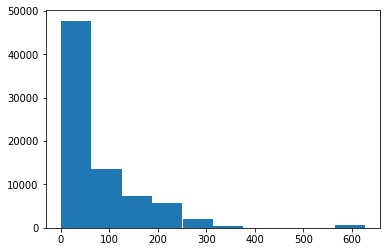

In [28]:
data_test['time'] = data_test.groupby(['loadingOrder'])['work_time'].transform('max')
plt.hist(data_test['time'])

(array([3481529., 2926639., 3724962., 5700208., 4065431., 2098352.,
         745970.,  472032.,  186467.,  130499.]),
 array([   0. ,  180.9,  361.8,  542.5,  723.5,  904.5, 1085. , 1266. ,
        1447. , 1628. , 1809. ], dtype=float16),
 <a list of 10 Patch objects>)

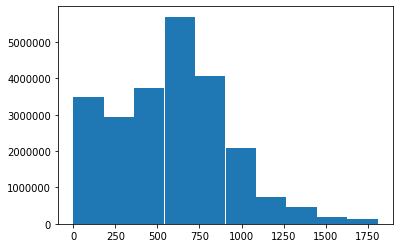

In [35]:
plt.hist(data_train['time'])

(array([2588802., 2758664., 3442846., 2877172., 1537017.,  313099.,
          35959.,   55397.,   96588.,   98760.]),
 array([   0.,  207.,  414.,  621.,  828., 1035., 1242., 1449., 1656.,
        1863., 2070.], dtype=float16),
 <a list of 10 Patch objects>)

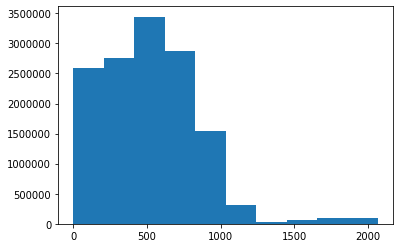

In [433]:
plt.hist(null_data['time'])

In [36]:
data_test['time'].max()/data_train['time'].max()

0.3467

In [37]:
data_test['time'].median()/data_train['time'].median()

0.0407

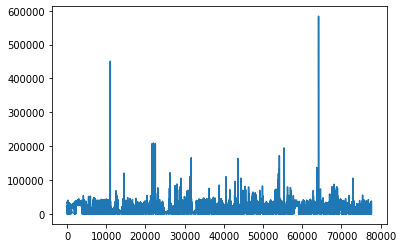

In [38]:
data_test.average_speed.plot()

In [441]:
#null_data['work_time_diff'] = null_data.groupby(['loadingOrder'])['work_time'].transform(lambda x : x.diff(1))

In [456]:
#null_data = null_data[~null_data.loadingOrder.isin(null_data.loc[null_data.work_time_diff>24].loadingOrder.unique())]

In [37]:
data_train.loadingOrder.nunique()

1474

In [8]:
def get(a):
    for i in range(1,len(a)):
        a[i] += a[i-1]
    return a
data_test['work_time_diff'] = data_test.groupby(['loadingOrder'])['work_time'].transform(lambda x : x.diff(1))
data_test['jiange'] = 0
data_test.loc[data_test['work_time_diff']>12,'jiange'] = 1
a = data_test['jiange'].values
a = get(a)

data_test['period'] = a
data_test['periods'] = data_test.groupby(['loadingOrder'])['period'].transform(lambda x :x-x.min())


In [9]:
data_test = data_test[data_test['periods'] == 0]

In [207]:
data_test[data_test.loadingOrder.isin(data_test.loc[data_test.periods>0].loadingOrder.unique())].loadingOrder.unique()

array(['AC860038925693', 'EI581767201011', 'FA712454830300',
       'GP579408164626', 'MI815639344195', 'UD485960146467',
       'WO664383377169', 'ZE957090425955', 'ZS950908209190'], dtype=object)

In [57]:
data_train[data_train.loadingOrder.isin(data_train.loc[data_train.periods>0].loadingOrder.unique())].loadingOrder.unique()

array(['AB690600150591', 'AL530484821704', 'AV581038137582',
       'BA482715641502', 'BE772978456555', 'BF675259184277',
       'BL708735009599', 'BL962431411313', 'BM229728180245',
       'BM646149208370', 'BP352984890027', 'BZ991948604704',
       'CC120572915751', 'CF338107851942', 'CH220691461221',
       'CN221927333794', 'CV440429507544', 'CY167908241686',
       'CZ651841591549', 'DB249537838867', 'DI608641952392',
       'DJ586118297145', 'DM167520702862', 'DN543066860487',
       'DQ820007575657', 'DS853965915068', 'DV837755069853',
       'DW551811377267', 'DY104055768858', 'EB136178635924',
       'EC134928176075', 'ED919086125715', 'EE910012535393',
       'EG981713723154', 'EH792048548709', 'EI235057046326',
       'EK371707406623', 'EN214940711416', 'EN361647484585',
       'EN802039631720', 'ER252730294217', 'FB758905409344',
       'FC494162381831', 'FC583890824665', 'FF318308761290',
       'FL141682497473', 'FL774335096267', 'FT101712392347',
       'FU500578962059',

In [59]:
data_train[data_train.loadingOrder=='ZQ431848055598']

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,lat_diff,lon_diff,speed_diff,diff_minutes,anchor,destins,start,q_lat,q_lon,lat_dis_diff,lon_dis_diff,base_dis_diff,d_lon,d_lat,Haversine,manhattan,mmin,work_time,average_speed,max_dis,d_lat1,d_lon1,cha_d_lon,cha_d_lat,len,work_time_diff,jiange,period,periods
7357570,ZQ431848055598,JONOCD,2019-01-31 03:44:07+00:00,113.875,22.453125,K3878954877,0.0,23936.0,SHEKOU,2019-01-30T13:00:00.000Z,moored,Coastal AIS,CNSHK-MYPKG,0.0,0.0,NaN,NaN,0,MYPKG,CNSHK,22.5625,113.875,0.106323,0.011940,0.106995,101.375,3.011719,2550524.5,3553771.5,2019-01-31 03:44:07+00:00,0.000000,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,NaN,216,216,0
7357571,ZQ431848055598,JONOCD,2019-01-31 03:50:07+00:00,113.875,22.453125,K3878954877,0.0,15448.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,6.0,0,MYPKG,CNSHK,22.5625,113.875,0.106323,0.011940,0.106995,101.375,3.011719,2550524.5,3553771.5,2019-01-31 03:44:07+00:00,0.099976,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.099976,216,216,0
7357572,ZQ431848055598,JONOCD,2019-01-31 03:56:08+00:00,113.875,22.453125,K3878954877,0.0,20112.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,6.0,0,MYPKG,CNSHK,22.5625,113.875,0.106323,0.011940,0.106995,101.375,3.011719,2550524.5,3553771.5,2019-01-31 03:44:07+00:00,0.200317,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.100342,216,216,0
7357573,ZQ431848055598,JONOCD,2019-01-31 04:05:08+00:00,113.875,22.453125,K3878954877,0.0,17376.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,9.0,0,MYPKG,CNSHK,22.5625,113.875,0.106323,0.011940,0.106995,101.375,3.011719,2550524.5,3553771.5,2019-01-31 03:44:07+00:00,0.350342,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.150024,216,216,0
7357574,ZQ431848055598,JONOCD,2019-01-31 04:10:31+00:00,113.875,22.453125,K3878954877,0.0,18720.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,5.0,0,MYPKG,CNSHK,22.5625,113.875,0.106323,0.011940,0.106995,101.375,3.011719,2550524.5,3553771.5,2019-01-31 03:44:07+00:00,0.439941,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.089600,216,216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367012,ZQ431848055598,JONOCD,2019-02-04 13:20:06+00:00,101.375,3.011719,K3878954877,0.0,5280.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,0.0,0,MYPKG,CNSHK,22.5625,113.875,19.546875,12.484375,23.203125,101.375,3.011719,0.0,0.0,2019-01-31 03:44:07+00:00,105.625000,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.062500,217,217,1
7367013,ZQ431848055598,JONOCD,2019-02-04 13:20:47+00:00,101.375,3.011719,K3878954877,0.0,5472.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,0.0,0,MYPKG,CNSHK,22.5625,113.875,19.546875,12.484375,23.203125,101.375,3.011719,0.0,0.0,2019-01-31 03:44:07+00:00,105.625000,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.000000,217,217,1
7367014,ZQ431848055598,JONOCD,2019-02-04 13:21:27+00:00,101.375,3.011719,K3878954877,0.0,5768.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,0.0,0,MYPKG,CNSHK,22.5625,113.875,19.546875,12.484375,23.203125,101.375,3.011719,0.0,0.0,2019-01-31 03:44:07+00:00,105.625000,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.000000,217,217,1
7367015,ZQ431848055598,JONOCD,2019-02-04 13:22:06+00:00,101.375,3.011719,K3878954877,0.0,5860.0,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKG,0.0,0.0,0.0,0.0,0,MYPKG,CNSHK,22.5625,113.875,19.546875,12.484375,23.203125,101.375,3.011719,0.0,0.0,2019-01-31 03:44:07+00:00,105.625000,0.0,2550524.5,3.034709,101.361204,0.013796,0.02299,9447,0.000000,217,217,1


In [24]:
data_test = data_test[data_test.periods==0]

In [10]:
data_train['work_time_diff'] = data_train.groupby(['loadingOrder'])['work_time'].transform(lambda x : x.diff(1))
data_train['jiange'] = 0
data_train.loc[data_train['work_time_diff']>12,'jiange'] = 1
b = data_train['jiange'].values
def get(a):
    for i in range(1,len(a)):
        a[i] += a[i-1]
    return a
b = get(b)

data_train['period'] = b
data_train['periods'] = data_train.groupby(['loadingOrder'])['period'].transform(lambda x :x-x.min())

In [14]:
data_test['periods'].unique()

array([0], dtype=int64)

In [11]:
#根据test的起始点选择train .oadingOrder
data_train =data_train[data_train['destins'].isin(data_test.destins.unique())]
data_train = data_train[data_train['start'].isin(data_test.start.unique())]

In [12]:
#根据目的港是否接近选择订单
def choice(data_train):
    train_port = port[port['TRANS_NODE_NAME'].isin(data_train['destins'].unique())]
    train_port.rename(columns={'TRANS_NODE_NAME':'destins','LONGITUDE':'d_lon1','LATITUDE':'d_lat1'},inplace=True)
    train_port = train_port.drop_duplicates('destins')
    data_train =data_train.merge(train_port[['destins','d_lat1','d_lon1']],on='destins',how='left')
    data_train['cha_d_lon'] = abs(data_train['d_lon']-data_train['d_lon1'])
    data_train['cha_d_lat'] = abs(data_train['d_lat']-data_train['d_lat1'])
    oder1 = data_train[(data_train['cha_d_lat']<0.25) & (data_train['cha_d_lon']<0.25)].loadingOrder.unique() 
    data_train = data_train[data_train['loadingOrder'].isin(oder1)]
    return data_train
data_train = choice(data_train)

In [11]:
data_train['len'] = data_train['loadingOrder'].map(data_train['loadingOrder'].value_counts())
data_train['a'] = 0
data_train.loc[data_train.average_speed<1,'a'] = 1
data_train['a_sum'] = data_train.groupby(['loadingOrder'])['a'].transform('sum')
data_train['a_sum_ration']  = data_train['a_sum']/data_train['len']


(array([ 7515., 13107.,  2414.,   947.,  5340.,  3973., 11918., 14560.,
        12750.,  5130.]),
 array([9.5541787e+03, 1.8830698e+06, 3.7565852e+06, 5.6301010e+06,
        7.5036165e+06, 9.3771320e+06, 1.1250648e+07, 1.3124163e+07,
        1.4997679e+07, 1.6871194e+07, 1.8744710e+07], dtype=float32),
 <a list of 10 Patch objects>)

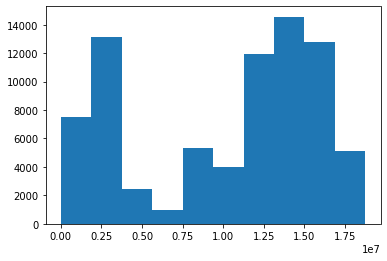

In [50]:
plt.hist(data_test.max_dis)

In [52]:
data_test.max_dis.min()

9554.1787109375

(array([ 379987., 1164301.,  566983.,  383739.,  664320., 1106938.,
        1163330.,  622379.,  609975., 1492855.]),
 array([       0. ,  1874505.8,  3749011.5,  5623517.5,  7498023. ,
         9372529. , 11247035. , 13121541. , 14996046. , 16870552. ,
        18745058. ], dtype=float32),
 <a list of 10 Patch objects>)

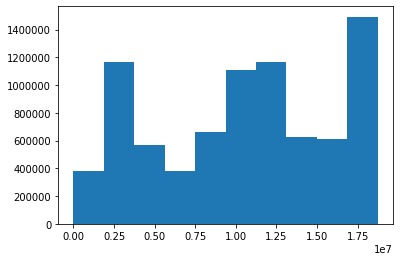

In [51]:
plt.hist(data_train.max_dis)

In [616]:
#data_train = data_train[data_train['a_sum_ration']<0.7]

In [13]:
data_train = data_train[data_train.max_dis>9554.1787109375]

In [14]:
data_train['len'] = data_train['loadingOrder'].map(data_train['loadingOrder'].value_counts())
data_test['len'] = data_test['loadingOrder'].map(data_test['loadingOrder'].value_counts())
data_train = data_train[data_train['len']>100]

In [125]:
data_test.diff_minutes.max()

21820.0

In [15]:
data_train['work_time_diff'] = data_train.groupby(['loadingOrder'])['work_time'].transform(lambda x : x.diff(1))
data_train = data_train[~data_train.loadingOrder.isin(data_train.loc[data_train.work_time_diff>72].loadingOrder.unique())]

In [447]:
# null_data['len'] = null_data['loadingOrder'].map(null_data['loadingOrder'].value_counts())
# null_data = null_data[null_data['len']>1000]
# null_data = null_data[null_data.max_dis>50000]
# null_data = null_data[null_data['time']>48]
# null_data = null_data[null_data['time']<1230]

In [ ]:
# null_data = null_data.groupby(['loadingOrder'])

In [554]:
# from sklearn.utils import shuffle
# a = shuffle(null_data.loadingOrder.unique())

In [555]:
# c_oder = a[:300]

In [557]:
# null_data = null_data[null_data['loadingOrder'].isin(c_oder)]

In [513]:
data_train['a'] = 0
data_train.loc[data_train.average_speed<1,'a'] = 1
data_train['a_sum'] = data_train.groupby(['loadingOrder'])['a'].transform('sum')
data_train['a_sum_ration']  = data_train['a_sum']/data_train['len']

In [ ]:
data_test['a'] = 0
data_test.loc[data_test.average_speed<1,'a'] = 1
data_test['a_sum'] = data_test.groupby(['loadingOrder'])['a'].transform('sum')
# data_test['a_sum_ration']  = data_test['a_sum']/data_test['len']

(array([ 20845.,  16822.,  39247.,  42202.,  68793.,  97709., 129909.,
        140542., 192023., 199904.]),
 array([0.04639175, 0.14034413, 0.2342965 , 0.32824887, 0.42220125,
        0.51615362, 0.610106  , 0.70405837, 0.79801074, 0.89196312,
        0.98591549]),
 <a list of 10 Patch objects>)

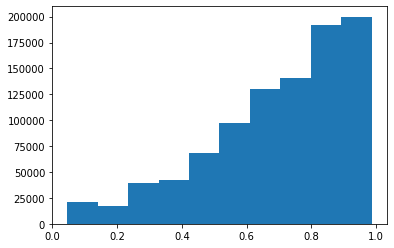

In [515]:
plt.hist(data_train['a_sum_ration'])

In [244]:
data_train.loadingOrder.nunique()

1342

In [19]:
data_train['trace_len'] = data_train['TRANSPORT_TRACE'].apply(lambda x : len(x.split('-')))

In [20]:
data_test['trace_len'] = data_test['TRANSPORT_TRACE'].apply(lambda x : len(x.split('-')))

In [23]:
data_test['TRANSPORT_TRACE'].unique()

array(['CNSHK-CLVAP', 'CNYTN-MATNG', 'CNSHK-SGSIN', 'HKHKG-FRFOS',
       'CNSHK-INMAA', 'CNSHK-JPHKT',
       'CNYTN-TWKHH-CNSHA-CNNBG-MXZLO-SVAQJ', 'CNSHK-BHBAH',
       'CNYTN-MXZLO', 'CNYTN-PAONX', 'CNSHK-MYTPP',
       'CNSHK-MYTPP-MUPLU-ZADUR', 'CNYTN-CVRAI', 'CNSHK-ZADUR',
       'CNSHK-CLSAI', 'CNYTN-ARENA', 'CNYTN-MYTPP-EGSUE-MATNG-MACAS',
       'CNNSA-CMKBI', 'CNYTN-SGSIN-ESALG-GMBJL',
       'CNYTN-VNVUT-SGSIN-FRLEH', 'CNNSA-NAWVB', 'CNSHK-ESVAL',
       'CNNSA-GHTEM', 'LTKLJ-DEHAM-HKHKG', 'CNSHK-GRPIR',
       'CNYTN-CNXAM-CNSGH-PAONX-PAMIT-GTIZ4-HNPCR-PAMIT-PAONX-CRLIO',
       'HUNGARY-HON', 'CNSHK-EGPSD', 'CNSHK-KRINC',
       'CNSHK-SGSIN-MTMLA-DZALG', 'CNSHK-ESALG', 'CNNSA-SGSIN-AEJEA',
       'CNYTN-HKHKG-SGSIN-BRRIO-BRSSZ-BRPNG-BRNVT-UYMVD',
       'CNYTN-MYTPP-FRFOS-FRMRS-EGSUE-TNTUN',
       'CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZLO-PABLB-PAMIT-COCTG-JMKIN-DOCAU',
       'COBUN-HKHKG', 'CNYTN-CAVAN', 'CNYTN-PHBTG', 'CNSHK-PKQCT',
       'CNSHK-GRPIR-ITSPE-I

In [21]:
data_train.trace_len.unique()

array([ 2,  4,  3,  6,  7,  5, 10,  8], dtype=int64)

In [22]:
data_test.trace_len.unique()

array([ 2,  6,  4,  5,  3, 10,  8, 13, 16,  7], dtype=int64)

In [818]:
data_train = data_train[data_train['trace_len']==2]

In [559]:
t = pd.concat([data_train,null_data],axis = 0)

In [560]:
data_train = t

In [16]:
data_train.drop_duplicates(['loadingOrder','vesselMMSI','timestamp','longitude','latitude','TRANSPORT_TRACE'],inplace=True,keep ='last')
data_test.drop_duplicates(['loadingOrder','vesselMMSI','timestamp','longitude','latitude','TRANSPORT_TRACE'],inplace=True,keep ='last')

In [25]:
# 将异常的direction删除
print(data_train.shape, data_train.loadingOrder.nunique())
data_train = data_train[~((data_train["direction"] > 36000) | (data_train["direction"] < 0))]
print(data_train.shape, data_train.loadingOrder.nunique())
# test_data中删除异常的direction不会改变订单总数
temp = data_test[~(data_test["direction"] < 0)]
print(data_test.shape, temp.shape, data_test.loadingOrder.nunique(), temp.loadingOrder.nunique())
data_test = data_test[~(data_test["direction"] < 0)]

(5433756, 43) 1382
(5413215, 43) 1382
(50568, 36) (50510, 36) 219 217


In [17]:
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop = True)

In [181]:
data_test['work_time_diff'] = data_test.groupby(['loadingOrder'])['work_time'].transform(lambda x : x.diff(1))
data_test['jiange'] = 0
data_test.loc[data_test['work_time_diff']>48,'jiange'] = 1

In [19]:
data_test['jiange_sum'] = data_test.groupby(['loadingOrder'])['jiange'].transform('sum')

In [20]:
data_train['jiange_sum'] = data_train.groupby(['loadingOrder'])['jiange'].transform('sum')

In [ ]:
t = data_train[~data_train.loadingOrder.isin(data_train.loc[data_train.work_time_diff>100].loadingOrder.unique())]

In [549]:
data_train = data_train[~(data_train['TRANSPORT_TRACE'].isin(['null']))]

In [78]:
data_train.time.max()

1809.0

In [79]:
data_test.time.max()

627.0

In [18]:
def soreoccurring(x):
    unique, counts = np.unique(x, return_counts=True)
    counts[counts < 2] = 0
    counts[counts > 1] = 1
    return np.sum(counts * unique)
def pereoccurring_all(x):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    if x.size == 0:
        return np.nan
    value_counts = x.value_counts()
    reoccuring_values = value_counts[value_counts > 1].sum()
    if np.isnan(reoccuring_values):
        return 0
    return reoccuring_values / x.size
def datapoint(x):
    if len(x) == 0:
        return np.nan
    unique, counts = np.unique(x, return_counts=True)
    if counts.shape[0] == 0:
        return 0
    return np.sum(counts > 1) / float(counts.shape[0])

In [19]:
def get_feet(data,fea):
    t=[]
    for i in fea:
        fs = feets.FeatureSpace(only = ['Amplitude',#'Con', # 'Autocor_length',
                       'Gskew',
                       # 'Meanvariance',
                   'MedianAbsDev', 'MedianBRP',
                        'PairSlopeTrend',
                   # 'Autocor_length',
                   # 'AndersonDarling',
                       'Q31',
                       # 'Rcs',
                 #  'SmallKurtosis'
                                       ])
        _, values = fs.extract(magnitude=data[i])
        a = dict(zip(_,values))
        a = pd.DataFrame(a,index=[0])
        a.columns =[i+'_'+j for j in a.columns]
        t.append(a)
        rst = t[0]
        for val in t[1:]:
            rst = pd.concat([rst,val],axis=1)
            rst.reset_index(drop=True, inplace=True)
    return rst

In [20]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'],format='%m%d %H:%M:%S')
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['minute'] = df['timestamp'].dt.minute
    return df
# def cross_num_fea(df,group_col,stat_col):
#     for i in group_col:
#         temp = df.groupby([i])
#         for j in stat_col:
#             if i==j:
#                 continue
#             df = df.merge(temp[j].agg('{}_{}_mean'.format(i,j)='mean','{}_{}_min'.format(i,j)= 'min',
#                                        '{}_{}_median'.format(i,j)='median',
#             '{}_{}_max'.format(i,j) ='max',
#                                        '{}_{}_std'.format(i,j) ='std'),on=i,how='left')
#     return df   
def cross_num_fea(df,group_col,stat_col):
    for i in (group_col):
        for j in stat_col:
            if j in i:
                continue
            df[i+'_'+j+'_mean'] = df.groupby([i])[j].transform('mean')
            df[i+'_'+j+'_max'] = df[j]-df.groupby([i])[j].transform('max')
            df[i+'_'+j+'_min'] = df.groupby([i])[j].transform('min')
            df[i+'_'+j+'_medain'] = df[j]-df.groupby([i])[j].transform('median')
            df[i+'_'+j+'_std'] = df.groupby([i])[j].transform('std')
#             df[i+'_'+j+'ptp'] = df.groupby([i])[j].transform('max')-df.groupby([i])[j].transform('min')
#             df[i+'_'+j+'qu'] = df[j]-df.groupby([i])[j].transform('min')
#             df[i+'_'+j+'qu1'] = df[j]-df.groupby([i])[j].transform('mean')         
    return df

In [21]:
def get_fea(df):
    df['lat_max_lat_min'] = df['latitude_max'] - df['latitude_min']
    df['lon_max_lon_min'] = df['longitude_max'] - df['longitude_min']
    df['lon_max_lat_min'] = df['longitude_max'] - df['latitude_min']
    df['lat_max_lon_min'] = df['latitude_max'] - df['longitude_min']
    df['slope'] = df['lon_max_lon_min'] / np.where(df['lat_max_lat_min']==0, 0.001, df['lat_max_lat_min'])
    df['area'] = df['lat_max_lat_min'] * df['lon_max_lon_min']
    del df['lat_max_lat_min'],df['lon_max_lon_min']
    df['lon_mode_lat_mode'] = df['longitude_mode'] - df['latitude_mode']
    df['lon_mode*lat_mode'] = df['longitude_mode'] * df['latitude_mode']
    df['lon_mode/lat_mode'] = df['longitude_mode'] / (df['latitude_mode']+1e-10)
    df['lat_mode/lon_mode'] = df['latitude_mode'] / (df['longitude_mode']+1e-10)
    df['lat_max_lat_mode'] = df['latitude_max'] - df['latitude_mode']
    df['lon_max_lat_mode'] = df['longitude_max'] - df['latitude_mode']
    df['lat_max_lon_mode'] = df['latitude_max'] - df['longitude_mode']
    df['lon_max_lon_mode'] = df['longitude_max'] - df['longitude_mode']
    df['lat_min_lat_mode'] = df['latitude_mode'] -df['latitude_min']
    df['lon_min_lat_mode'] =  df['latitude_mode']-df['longitude_min'] 
    df['lat_min_lon_mode'] = df['longitude_mode'] -df['latitude_min']
    df['lon_min_lon_mode'] =  df['longitude_mode']- df['longitude_min']
    df['a_v'] = df['Haversine_ptp']/df['work_time_ptp']
    return df

In [22]:
def medianAbsDev(data):
    mad = np.median(np.abs(data-np.median(data)))
    return mad
def stat(data,c,name):
    c[name + '_max'] = np.max(data.tolist())
    c[name + '_min'] = np.min(data.tolist())
    c[name + '_mean'] = np.mean(data.tolist())
    c[name + '_ptp'] = np.ptp(data)
    c[name + '_std'] = np.var(data.tolist())
    c[name + '_skewness'] = skew(data.tolist())
    c[name + '_kurtosis'] = kurtosis(data.tolist())
    c[name+ '_0.25']=np.percentile(data, 25)
    c[name+ '_0.5']=np.percentile(data, 50)
    c[name+ '_0.75']=np.percentile(data, 75)
#     c[name+'_high5']=data.mean()+5*data.std()
#     c[name+'_high3']=data.mean()+3*data.std()
#     c[name+'_low5']=data.mean()-5*data.std()
#     c[name+'_low3']=data.mean()-3*data.std()
    c[name+'_soreoccurring']=soreoccurring(data)
    c[name+'_pereoccurring_all']=pereoccurring_all(data)
    c[name+'_datapoint']=datapoint(data)
    c[name+'_mode']=mode(data)[0]
#    c[name+'_mad']=mean_absolute_deviation(data)
 #   c[name+'_medianBRP'] = medianbrp(data)
    c[name+'_medianAbsDev']=medianAbsDev(data.tolist())
#    c[name+'_beyond1_std']=beyond1_std(data)
    return c

def stat1(data,c,name):
    c[name + '_max'] = np.max(data.tolist())
    c[name + '_min'] = np.min(data.tolist())
    c[name + '_mean'] = np.mean(data.tolist())
    c[name + '_ptp'] = np.ptp(data)
    c[name + '_std'] = np.var(data.tolist())
    c[name+ '_0.25']=np.percentile(data, 25)
    c[name+ '_0.5']=np.percentile(data, 50)
    c[name+ '_0.75']=np.percentile(data, 75)
#     c[name+'_high5']=data.mean()+5*data.std()
#     c[name+'_high3']=data.mean()+3*data.std()
#     c[name+'_low5']=data.mean()-5*data.std()
#     c[name+'_low3']=data.mean()-3*data.std()
    c[name+'_soreoccurring']=soreoccurring(data)
    c[name+'_pereoccurring_all']=pereoccurring_all(data)
    c[name+'_datapoint']=datapoint(data)
 #   c[name+'_medianBRP'] = medianbrp(data)
    c[name+'_medianAbsDev']=medianAbsDev(data.tolist())
 #   c[name+'datapoint']=datapoint(data)
#    c[name+'_beyond1_std']=beyond1_std(data)
    return c
def stat2(data,c,name):
    c[name + '_max'] = data.max()
    c[name + '_min'] = data.min()
    c[name + '_mean'] = data.mean()
    c[name+ '_0.5']=np.percentile(data, 50)
#    c[name + '_ptp'] = data.ptp()
#    c[name + '_std'] = np.var(data.tolist())
    c[name+'_soreoccurring']=soreoccurring(data)
    c[name+'_medianAbsDev'] = medianAbsDev(data)
    c[name+'_pereoccurring_all']=pereoccurring_all(data)
    c[name+'_datapoint']=datapoint(data.tolist())
    return c
    

In [ ]:

# def calculate_aggregate(values):
#     agg_measures = {
#         'avg': np.mean(values),
#         'std': np.std(values),
#         'var': np.var(values),
#         'med': np.median(values),
#         '10p': np.percentile(values, 10),
#         '25p': np.percentile(values, 25),
#         '50p': np.percentile(values, 50),
#         '75p': np.percentile(values, 75),
#         '90p': np.percentile(values, 90),
#         'iqr': np.percentile(values, 75) - np.percentile(values, 25),
#         'iqm': interquartile_range_mean(values),
#         'mad': mean_absolute_deviation(values),
#         'cov': 1.0 * np.mean(values) / np.std(values),
#         'gin': gini_coefficient(values),
#         'skw': stats.skew(values),
#         'kur': stats.kurtosis(values),
#         'sum': np.sum(values)
#     }

#     return agg_measures 

In [ ]:
data_train

In [2477]:
data = data_train[['loadingOrder','longitude','latitude','work_time','direction','base_dis_diff']].append(data_test[['loadingOrder','longitude','latitude','direction','base_dis_diff']]).reset_index(drop=True)

In [23]:
from tqdm import tqdm
df1 =  data_train[['loadingOrder','TRANSPORT_TRACE']].append(data_test[['loadingOrder','TRANSPORT_TRACE']]).reset_index(drop=True)
df1 = df1.drop_duplicates('loadingOrder').reset_index(drop=True)
for i in tqdm(['TRANSPORT_TRACE']):
    df1[i] = df1[i].map(dict(zip(df1[i].unique(),(range(df1[i].nunique())))))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


In [106]:
df1

,loadingOrder,TRANSPORT_TRACE
0,AA236935066990,0
1,AA597788695392,1
2,AB309086787273,2
3,AB690600150591,3
4,AB895237846468,4
...,...,...
8735,ZS950908209190,42
8736,ZU783006492351,67
8737,ZX552539758501,140
8738,ZY473040866147,101


In [87]:
df1.loadingOrder.nunique()

2296

In [2478]:
def cut_bins(raw_data, col_name=None, q=49):
    features, bins = pd.qcut(raw_data[col_name], q=q, retbins=True, duplicates="drop")
    labels = list(range(len(bins) - 1))
    features, bins = pd.qcut(raw_data[col_name], labels=labels, q=q, retbins=True, duplicates="drop")
    return features, bins, labels
MAX_CATE = 199
data["longitude_cate"], x_bins, x_labels = cut_bins(data, col_name="longitude", q=MAX_CATE)
data["latitude_cate"], y_bins, y_labels = cut_bins(data, col_name="latitude", q=MAX_CATE)
# data["x_sub_y_cate"], x_sub_y_bins, x_sub_y_labels = cut_bins(data, col_name="x_sub_y", q=MAX_CATE)
data["distance_cate"], dist_bins, dist_labels = cut_bins(data, col_name="base_dis_diff", q=MAX_CATE)
MAX_CATE = 120
data["direct_cate"], speed_bins, speed_labels = cut_bins(data, col_name="direction", q=MAX_CATE)

In [2479]:
df = data[['loadingOrder','work_time']].drop_duplicates('loadingOrder').reset_index(drop=True)

In [ ]:
def emb(df, f1, f2,emb_size):
#   emb_size = 64
    print('====================================== {} {} ======================================'.format(f1, f2))
    tmp = df.groupby(f1, as_index=False)[f2].agg({'{}_{}_list'.format(f1, f2): list})
    sentences = tmp['{}_{}_list'.format(f1, f2)].values.tolist()
    del tmp['{}_{}_list'.format(f1, f2)]
    for i in range(len(sentences)):
        sentences[i] = [str(x) for x in sentences[i]]
    model = Word2Vec(sentences, size=emb_size, window=8, min_count=5, sg=0, hs=1, seed=2019,workers=48, iter=10)
    emb_matrix = []
  #  emb_matrix = np.array(emb_matrix)
    for seq in sentences:
        vec = []
        for w in seq:
            if w in model:
                vec.append(model[w])
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        else:
            emb_matrix.append([0] * emb_size)
    emb_matrix = np.array(emb_matrix)
    for i in range(emb_size):
        tmp['{}_{}_emb_{}'.format(f1, f2, i)] = emb_matrix[:, i]
    del model, emb_matrix, sentences
    tmp = reduce_mem_usage(tmp)
    # print('runtime:', time.time() - t)
    return tmp

emb_cols =  [['loadingOrder','longitude_cate'],['loadingOrder','latitude_cate'],['loadingOrder','direct_cate']]
for f1, f2 in emb_cols:
    df = df.merge(emb(data, f1, f2,20), on=f1, how='left')

In [ ]:
df = df.merge(df1,on='loadingOrder',how = 'left')

In [ ]:
fea = [i for i in df.columns if i not in ['work_time']]
trn_index = ~df.work_time.isnull()
train_df = df[trn_index][fea]
test_df = df[~trn_index][fea]

In [ ]:
 [0.15,0.21,0.35,0.49,0.56,0.62,0.73,0.82,0.92]

In [ ]:
oder = train_data.loadingOrder.unique()

In [ ]:
from sklearn.utils import shuffle
t_oder =shuffle(oder)[:50]

In [ ]:
train_2 = data_train[data_train.loadingOrder.isin(t_oder)]

In [27]:
data_train.loadingOrder.unique()[:10]

array(['AC449966542855', 'AH959858555885', 'AI338314636212',
       'AI556878934887', 'AJ719144254201', 'AL455172449176',
       'AL793494777774', 'AQ327979205838', 'AQ678418145223',
       'AS294921524818'], dtype=object)

In [43]:
tv_features

,Haversine_0.25,Haversine_0.5,Haversine_0.75,Haversine_datapoint,Haversine_max,Haversine_mean,Haversine_medianAbsDev,Haversine_min,Haversine_pereoccurring_all,Haversine_ptp,Haversine_soreoccurring,Haversine_std,anchor_ratio,anchor_sum,average_speed_0.25,average_speed_0.5,average_speed_0.75,average_speed_datapoint,average_speed_max,average_speed_mean,average_speed_medianAbsDev,average_speed_min,average_speed_pereoccurring_all,average_speed_ptp,average_speed_soreoccurring,average_speed_std,base_dis_diff_0.25,base_dis_diff_0.5,base_dis_diff_0.75,base_dis_diff_datapoint,base_dis_diff_max,base_dis_diff_mean,base_dis_diff_medianAbsDev,base_dis_diff_min,base_dis_diff_pereoccurring_all,base_dis_diff_ptp,base_dis_diff_soreoccurring,base_dis_diff_std,direction_0.25,direction_0.5,direction_0.75,direction_datapoint,direction_kurtosis,direction_max,direction_mean,direction_medianAbsDev,direction_min,direction_mode,direction_pereoccurring_all,direction_ptp,direction_skewness,direction_soreoccurring,direction_std,hour_Haversine_max_0.5,hour_Haversine_max_datapoint,hour_Haversine_max_max,hour_Haversine_max_mean,hour_Haversine_max_medianAbsDev,hour_Haversine_max_min,hour_Haversine_max_pereoccurring_all,hour_Haversine_max_soreoccurring,hour_Haversine_max_x_0.5,hour_Haversine_max_x_datapoint,hour_Haversine_max_x_max,hour_Haversine_max_x_mean,hour_Haversine_max_x_medianAbsDev,hour_Haversine_max_x_min,hour_Haversine_max_x_pereoccurring_all,hour_Haversine_max_x_soreoccurring,hour_Haversine_max_y_0.5,hour_Haversine_max_y_datapoint,hour_Haversine_max_y_max,hour_Haversine_max_y_mean,hour_Haversine_max_y_medianAbsDev,hour_Haversine_max_y_min,hour_Haversine_max_y_pereoccurring_all,hour_Haversine_max_y_soreoccurring,hour_Haversine_mean_0.5,hour_Haversine_mean_datapoint,hour_Haversine_mean_max,hour_Haversine_mean_mean,hour_Haversine_mean_medianAbsDev,hour_Haversine_mean_min,hour_Haversine_mean_pereoccurring_all,hour_Haversine_mean_soreoccurring,hour_Haversine_mean_x_0.5,hour_Haversine_mean_x_datapoint,hour_Haversine_mean_x_max,hour_Haversine_mean_x_mean,hour_Haversine_mean_x_medianAbsDev,hour_Haversine_mean_x_min,hour_Haversine_mean_x_pereoccurring_all,hour_Haversine_mean_x_soreoccurring,hour_Haversine_mean_y_0.5,hour_Haversine_mean_y_datapoint,hour_Haversine_mean_y_max,hour_Haversine_mean_y_mean,hour_Haversine_mean_y_medianAbsDev,hour_Haversine_mean_y_min,hour_Haversine_mean_y_pereoccurring_all,hour_Haversine_mean_y_soreoccurring,hour_Haversine_median_0.5,hour_Haversine_median_datapoint,hour_Haversine_median_max,hour_Haversine_median_mean,hour_Haversine_median_medianAbsDev,hour_Haversine_median_min,hour_Haversine_median_pereoccurring_all,hour_Haversine_median_soreoccurring,hour_Haversine_median_x_0.5,hour_Haversine_median_x_datapoint,hour_Haversine_median_x_max,hour_Haversine_median_x_mean,hour_Haversine_median_x_medianAbsDev,hour_Haversine_median_x_min,hour_Haversine_median_x_pereoccurring_all,hour_Haversine_median_x_soreoccurring,hour_Haversine_median_y_0.5,hour_Haversine_median_y_datapoint,hour_Haversine_median_y_max,hour_Haversine_median_y_mean,hour_Haversine_median_y_medianAbsDev,hour_Haversine_median_y_min,hour_Haversine_median_y_pereoccurring_all,hour_Haversine_median_y_soreoccurring,hour_Haversine_min_0.5,hour_Haversine_min_datapoint,hour_Haversine_min_max,hour_Haversine_min_mean,hour_Haversine_min_medianAbsDev,hour_Haversine_min_min,hour_Haversine_min_pereoccurring_all,hour_Haversine_min_soreoccurring,hour_Haversine_min_x_0.5,hour_Haversine_min_x_datapoint,hour_Haversine_min_x_max,hour_Haversine_min_x_mean,hour_Haversine_min_x_medianAbsDev,hour_Haversine_min_x_min,hour_Haversine_min_x_pereoccurring_all,hour_Haversine_min_x_soreoccurring,hour_Haversine_min_y_0.5,hour_Haversine_min_y_datapoint,hour_Haversine_min_y_max,hour_Haversine_min_y_mean,hour_Haversine_min_y_medianAbsDev,hour_Haversine_min_y_min,hour_Haversine_min_y_pereoccurring_all,hour_Haversine_min_y_soreoccurring,hour_Haversine_std_0.5,...,minute_speed_std_y_soreoccurring,minute_work_ti

In [477]:
data_train['loadingOrder'].nunique()

1801

In [ ]:
  [(0,0.17),(0,0.28),(0,0.35),(0.1,0.49),(0.2,0.56),(0.2,0.62),(0.3,0.73),(0.4,0.82),(0.5,0.92)]

In [147]:
len(data_train.periods.unique())

12

In [150]:
np.random.randint(0,data_train.periods.max()-1)

6

In [24]:
def basic(k,data):
    data_train = data.copy()
    rst=[]
#    train_list =  [0.17,0.28,0.35,0.49,0.56,0.62,0.73,0.82,0.92]

    randoms=np.random.RandomState(5)
    train_list =  [(0,randoms.uniform(0.2, 0.3)),(0,0.35),(randoms.uniform(0.1, 0.2),0.49),(randoms.uniform(0.2, 0.3),0.56),(0.2,0.62),(0.3,0.73)]
    data = data_train[data_train['loadingOrder']==k]
    if len(data.periods.unique())==1:
        data = get_time(data)
        lifemax=data['work_time'].max()
        for a,b in train_list:
            data1=data[(data['work_time']<=lifemax*b)&(data['work_time']>=lifemax*a)]
            if len(data1) <20:
                data1 =data[(data['work_time']<=lifemax*b)]
            name = [ 'longitude', 'latitude', 'direction']
            data1 = cross_num_fea(data1,['hour'],name+ ['work_time','Haversine','average_speed','base_dis_diff'])
            name1 = ['work_time','Haversine','average_speed','base_dis_diff','speed']
            name2 = [i for i in data1.columns if 'hour_' in i and i not in 'hour' ]
            feet = get_feet(data1,name)
            c= {'loadingOrder': data1['loadingOrder'].unique(),
                            'label':lifemax-data1['work_time'].max(),
                            'anchor_sum':data1['anchor'].sum(),
                        'vesselMMSI':data1['vesselMMSI'].nunique(),
                                                 #     'ti':ti,
              #  'jiange_sum':data1['jiange'].sum(),
                             'anchor_ratio':data1['anchor'].sum()/len(data1),
                       # 'destins':data1['destins'].unique()[0],
                        # 'start':data1['start'].unique()[0],
                                }
            for j in name:    
                c=stat(data1[j].values,c,j)
            for j in name1:
                c = stat1(data1[j].values,c,j)
            for j in name2:
                c = stat2(data1[j].values,c,j)
            this_tv_features = pd.DataFrame(c, index=[0])
            this_tv_features = get_fea(this_tv_features)
            this_tv_features = pd.concat([this_tv_features,feet],axis= 1)
            rst.append(this_tv_features)
    else:
        data = get_time(data)
        lifemax=data['work_time'].max()
        sp = np.random.randint(0,data.periods.max())
        data1=data[data['periods']==sp]
        if len(data1) <20:
            data1 = data[data['periods']<=sp]
        name = [ 'longitude', 'latitude', 'direction']
        data1 = cross_num_fea(data1,['hour'],name+ ['work_time','Haversine','average_speed','base_dis_diff'])
        name1 = ['work_time','Haversine','average_speed','base_dis_diff','speed']
        name2 = [i for i in data1.columns if 'hour_' in i and i not in 'hour' ]
        feet = get_feet(data1,name)
        c= {'loadingOrder': data1['loadingOrder'].unique(),
                        'label':lifemax-data1['work_time'].max(),
                        'anchor_sum':data1['anchor'].sum(),
                    'vesselMMSI':data1['vesselMMSI'].nunique(),
                                             #     'ti':ti,
          #  'jiange_sum':data1['jiange'].sum(),
                         'anchor_ratio':data1['anchor'].sum()/len(data1),
                   # 'destins':data1['destins'].unique()[0],
                    # 'start':data1['start'].unique()[0],
                            }
        for j in name:    
            c=stat(data1[j].values,c,j)
        for j in name1:
            c = stat1(data1[j].values,c,j)
        for j in name2:
            c = stat2(data1[j].values,c,j)
        this_tv_features = pd.DataFrame(c, index=[0])
        this_tv_features = get_fea(this_tv_features)
        this_tv_features = pd.concat([this_tv_features,feet],axis= 1)
        rst.append(this_tv_features)
    tv_features = pd.concat(rst, axis=0)
    tv_features.reset_index(drop=True, inplace=True)
    return tv_features
#    tv_features.to_csv(out_dir+'%s'%idx,index=False)
#Parallel(n_jobs=8, verbose=10)(delayed(basic)(idx) for idx in L)

In [168]:
len(data.periods)

18343

In [62]:
data_train[data_train['loadingOrder']=='FV151852044777']

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,lat_diff,lon_diff,speed_diff,diff_minutes,anchor,destins,start,q_lat,q_lon,lat_dis_diff,lon_dis_diff,base_dis_diff,d_lon,d_lat,Haversine,manhattan,mmin,work_time,average_speed,max_dis,work_time_diff,jiange,period,periods,d_lat1,d_lon1,cha_d_lon,cha_d_lat,len,trace_len
1383005,FV151852044777,JCMFTA,2019-12-26 10:21:51+00:00,114.375,21.781250,R6302786626,21.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.015602,0.015602,21.0,3155.0,0,HKHKG,SIKOP,45.53125,13.726562,23.750000,100.625,103.4375,114.125,22.328125,66116.609375,86621.12500,2019-12-23 03:14:30+00:00,79.1250,30.530001,2318825.75,NaN,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383006,FV151852044777,JCMFTA,2019-12-26 10:42:20+00:00,114.375,21.843750,R6302786626,20.0,35808.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.062500,0.062500,-1.0,20.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.4375,18591.640625,2318825.75,0.3125,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383007,FV151852044777,JCMFTA,2019-12-26 10:43:01+00:00,114.375,21.843750,R6302786626,20.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,0.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.5000,0.000000,2318825.75,0.0625,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383008,FV151852044777,JCMFTA,2019-12-26 10:43:31+00:00,114.375,21.843750,R6302786626,20.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,0.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.5000,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383009,FV151852044777,JCMFTA,2019-12-26 10:43:48+00:00,114.375,21.843750,R6302786626,20.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,0.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.5000,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383613,FV151852044777,JCMFTA,2019-12-26 14:51:25+00:00,114.125,22.328125,R6302786626,4.0,34112.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383614,FV151852044777,JCMFTA,2019-12-26 14:51:45+00:00,114.125,22.328125,R6302786626,3.0,33312.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383615,FV151852044777,JCMFTA,2019-12-26 14:52:18+00:00,114.125,22.328125,R6302786626,2.0,32304.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383616,FV151852044777,JCMFTA,2019-12-26 14:53:19+00:00,114.125,22.328125,R6302786626,1.0,26592.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,1.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2


In [ ]:
#奇怪训练集理用parallel特别慢
train_ships = Parallel(n_jobs=-1, verbose=10)(delayed(basic)(k,data_train) for k in data_train['loadingOrder'].unique())
train_data = pd.concat(train_ships, axis=0)
train_data.reset_index(drop=True, inplace=True)

In [ ]:
# train_data = train_data.append(train_data_1).reset_index(drop=True)

In [ ]:
train_data.shape

In [65]:
data_train['loadingOrder'].unique()[:2]

array(['AB690600150591', 'AC449966542855'], dtype=object)

In [67]:
data_train[data_train['loadingOrder']=='FV151852044777']

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,lat_diff,lon_diff,speed_diff,diff_minutes,anchor,destins,start,q_lat,q_lon,lat_dis_diff,lon_dis_diff,base_dis_diff,d_lon,d_lat,Haversine,manhattan,mmin,work_time,average_speed,max_dis,work_time_diff,jiange,period,periods,d_lat1,d_lon1,cha_d_lon,cha_d_lat,len,trace_len
1383005,FV151852044777,JCMFTA,2019-12-26 10:21:51+00:00,114.375,21.781250,R6302786626,21.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.015602,0.015602,21.0,3155.0,0,HKHKG,SIKOP,45.53125,13.726562,23.750000,100.625,103.4375,114.125,22.328125,66116.609375,86621.12500,2019-12-23 03:14:30+00:00,79.1250,30.530001,2318825.75,NaN,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383006,FV151852044777,JCMFTA,2019-12-26 10:42:20+00:00,114.375,21.843750,R6302786626,20.0,35808.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.062500,0.062500,-1.0,20.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.4375,18591.640625,2318825.75,0.3125,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383007,FV151852044777,JCMFTA,2019-12-26 10:43:01+00:00,114.375,21.843750,R6302786626,20.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,0.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.5000,0.000000,2318825.75,0.0625,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383008,FV151852044777,JCMFTA,2019-12-26 10:43:31+00:00,114.375,21.843750,R6302786626,20.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,0.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.5000,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383009,FV151852044777,JCMFTA,2019-12-26 10:43:48+00:00,114.375,21.843750,R6302786626,20.0,35904.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,0.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.687500,100.625,103.3750,114.125,22.328125,59769.632812,79663.65625,2019-12-23 03:14:30+00:00,79.5000,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383613,FV151852044777,JCMFTA,2019-12-26 14:51:25+00:00,114.125,22.328125,R6302786626,4.0,34112.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383614,FV151852044777,JCMFTA,2019-12-26 14:51:45+00:00,114.125,22.328125,R6302786626,3.0,33312.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383615,FV151852044777,JCMFTA,2019-12-26 14:52:18+00:00,114.125,22.328125,R6302786626,2.0,32304.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,0.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2
1383616,FV151852044777,JCMFTA,2019-12-26 14:53:19+00:00,114.125,22.328125,R6302786626,1.0,26592.0,NaN,NaN,NaN,Coastal AIS,SIKOP-HKHKG,0.000000,0.000000,-1.0,1.0,0,HKHKG,SIKOP,45.53125,13.726562,23.203125,100.375,103.0625,114.125,22.328125,0.000000,0.00000,2019-12-23 03:14:30+00:00,83.6250,0.000000,2318825.75,0.0000,148,148,0,22.419915,114.139709,0.014709,0.09179,613,2


In [56]:
data_train['loadingOrder'].unique()[326:328]

array(['FV117587609198', 'FV151852044777'], dtype=object)

In [ ]:
res = []
for val in tqdm( data_train['loadingOrder'].unique()):
    res.append(basic(val,data_train))
train_data= pd.concat(res,axis=0).reset_index(drop=True)
#train.to_pickle('train_16.pkl')

 59%|██████████████████████████████████████████████▍                                | 754/1284 [20:19<16:10,  1.83s/it]

In [ ]:
# from scipy.stats import ks_2samp
# ks_2samp(train[col],test[col]).pvalue

In [112]:
data_train = data_train[data_train.periods<4]

In [113]:
data_train.loadingOrder.nunique()

2077

In [111]:
data_train['periods'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [69]:
data_train

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,lat_diff,lon_diff,speed_diff,diff_minutes,anchor,destins,start,q_lat,q_lon,lat_dis_diff,lon_dis_diff,base_dis_diff,d_lon,d_lat,Haversine,manhattan,mmin,work_time,average_speed,max_dis,d_lat1,d_lon1,cha_d_lon,cha_d_lat,len,a,a_sum,a_sum_ration,work_time_diff,jiange,jiange_sum,period,periods
0,AB690600150591,NWLGLX,2019-04-05 03:21:59+00:00,105.93750,4.382812,E1183558223,32.0,22048.0,CNXHK>SGSGP,2019-04-05T12:30:00.000Z,under way using engine,Coastal AIS,CNSHK-ZADUR,0.000000,0.000000,NaN,NaN,0,ZADUR,CNSHK,22.562500,113.875,18.171875,7.925781,19.828125,31.015625,-29.875000,8820003.0,10900098.0,2019-04-05 03:21:59+00:00,0.000000,0.000000,8820003.0,-29.868304,31.05008,0.034455,0.006696,263,1,148,0.562738,NaN,0,2,0,0
1,AB690600150591,NWLGLX,2019-04-05 09:18:05+00:00,105.31250,3.078125,E1183558223,27.0,20512.0,CNSHK>SGSIN PEBGA,2019-04-05T12:30:00.000Z,under way using engine,Coastal AIS,CNSHK-ZADUR,-1.304688,-1.304688,-5.0,356.0,1,ZADUR,CNSHK,22.562500,113.875,19.484375,8.546875,21.281250,31.015625,-29.875000,8684945.0,10698457.0,2019-04-05 03:21:59+00:00,5.933594,22756.119141,8820003.0,-29.868304,31.05008,0.034455,0.006696,263,0,148,0.562738,5.933594,0,2,0,0
2,AB690600150591,NWLGLX,2019-04-05 12:00:47+00:00,105.00000,2.468750,E1183558223,27.0,19840.0,CNSHK>SGSIN PEBGA,2019-04-05T12:30:00.000Z,under way using engine,Coastal AIS,CNSHK-ZADUR,-0.609375,-0.609375,0.0,162.0,1,ZADUR,CNSHK,22.562500,113.875,20.093750,8.859375,21.953125,31.015625,-29.875000,8619950.0,10602390.0,2019-04-05 03:21:59+00:00,8.648438,23968.759766,8820003.0,-29.868304,31.05008,0.034455,0.006696,263,0,148,0.562738,2.714844,0,2,0,0
3,AB690600150591,NWLGLX,2019-04-05 13:17:18+00:00,104.87500,2.169922,E1183558223,28.0,20144.0,CNSHK>SGSIN PEBGA,2019-04-05T12:30:00.000Z,under way using engine,Coastal AIS,CNSHK-ZADUR,-0.298828,-0.298828,1.0,76.0,0,ZADUR,CNSHK,22.562500,113.875,20.390625,8.984375,22.281250,31.015625,-29.875000,8590773.0,10557827.0,2019-04-05 03:21:59+00:00,9.921875,22879.199219,8820003.0,-29.868304,31.05008,0.034455,0.006696,263,0,148,0.562738,1.273438,0,2,0,0
4,AB690600150591,NWLGLX,2019-04-05 13:37:00+00:00,104.81250,2.093750,E1183558223,28.0,20512.0,CNSHK>SGSIN PEBGA,2019-04-05T12:30:00.000Z,under way using engine,Coastal AIS,CNSHK-ZADUR,-0.076172,-0.076172,0.0,19.0,1,ZADUR,CNSHK,22.562500,113.875,20.468750,9.046875,22.375000,31.015625,-29.875000,8580425.0,10543697.0,2019-04-05 03:21:59+00:00,10.250000,31514.419922,8820003.0,-29.868304,31.05008,0.034455,0.006696,263,0,148,0.562738,0.328125,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8127500,ZZ586794005049,OIEQNT,2019-02-04 02:32:25+00:00,-46.34375,-23.921875,O2545136013,0.0,17504.0,SANTOS,2019-02-03T16:00:00.000Z,moored,Coastal AIS,CNYTN-BRSSZ,0.000000,0.000000,0.0,3.0,0,BRSSZ,CNYTN,22.578125,114.250,46.500000,160.625000,167.250000,-46.343750,-23.921875,0.0,0.0,2019-01-06 16:03:25+00:00,682.500000,0.000000,18030104.0,-23.954513,-46.28402,0.059730,0.032638,3823,1,1344,0.351556,0.000000,1609,0,1609,0
8127501,ZZ586794005049,OIEQNT,2019-02-04 02:35:28+00:00,-46.34375,-23.921875,O2545136013,0.0,17504.0,SANTOS,2019-02-03T16:00:00.000Z,moored,Coastal AIS,CNYTN-BRSSZ,0.000000,0.000000,0.0,3.0,0,BRSSZ,CNYTN,22.578125,114.250,46.500000,160.625000,167.250000,-46.343750,-23.921875,0.0,0.0,2019-01-06 16:03:25+00:00,682.500000,0.000000,18030104.0,-23.954513,-46.28402,0.059730,0.032638,3823,1,1344,0.351556,0.000000,1609,0,1609,0
8127502,ZZ586794005049,OIEQNT,2019-02-04 02:38:30+00:00,-46.34375,-23.921875,O2545136013,0.0,17504.0,SANTOS,2019-02-03T16:00:00.000Z,moored,Coastal AIS,CNYTN-BRSSZ,0.000000,0.000000,0.0,3.0,0,BRSSZ,CNYTN,22.578125,114.250,46.500000,160.625000,167.250000,-46.343750,-23.921875,0.0,0.0,20

In [184]:
data_test = data_test[data_test['periods'] == 0]

In [214]:
def test_basic(k,data_test):
    rst=[]
    data = data_test[data_test['loadingOrder']==k]
    if k =='FA712454830300':
        data = data[data['periods']==0]
    data = get_time(data)
    name = [ 'longitude', 'latitude', 'direction']
    data1 =data
 #   not_fea = [i for i in data1.columns if i not in ['work_time','re_distance','lat_diff','lon_diff','speed_diff']]
    feet = get_feet(data1,name)
    data1 = cross_num_fea(data1,['hour'],name+ ['work_time','Haversine','average_speed','base_dis_diff'])
    name1 = ['work_time','Haversine','average_speed','base_dis_diff','speed']
    name2 = [i for i in data1.columns if 'hour_' in i and i not in 'hour' ]
    c= {'loadingOrder': data1['loadingOrder'].unique(),
                   # 'label':lifemax-data1['work_time'].max(),
                    'anchor_sum':data1['anchor'].sum(),
                   'vesselMMSI':data1['vesselMMSI'].nunique(),
                'jiange_sum':data1['jiange'].sum(),
                  #  'destins':data1['destins'].unique()[0],
                  #   'start':data1['start'].unique()[0],
                 'anchor_ratio':data1['anchor'].sum()/len(data1),
                        }
    for j in name:    
        c=stat(data1[j],c,j)
    for j in name1:
        c = stat1(data1[j],c,j)
    for j in name2:
        c = stat2(data1[j],c,j)
    this_tv_features = pd.DataFrame(c, index=[0])
    this_tv_features = get_fea(this_tv_features)
    this_tv_features = pd.concat([this_tv_features,feet],axis= 1)
    return this_tv_features
# ships = Parallel(n_jobs=-1, verbose=10)(delayed(test_basic)(k) for k in data_test['loadingOrder'].unique())
# test_data = pd.concat(ships, axis=0)
# test_data.reset_index(drop=True, inplace=True)

In [144]:
data_test.shape

(58682, 36)

In [215]:
test_res = []
for val in tqdm( data_test['loadingOrder'].unique()):
    test_res.append(test_basic(val,data_test))
test_data= pd.concat(test_res,axis=0).reset_index(drop=True)


 60%|███████████████████████████████████████████████▊                                | 131/219 [00:26<00:17,  5.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:43<00:00,  5.02it/s]


In [ ]:
train_data.to_pickle('train_20.pkl')
test.to_pickle('test_20.pkl')

In [107]:
train_data = train_data.merge(df1,on='loadingOrder',how = 'left')
test_data = test_data.merge(df1,on='loadingOrder',how = 'left')

In [ ]:
group = train_data['loadingOrder'].map(dict(zip(train_data['loadingOrder'].unique(),(range(train_data['loadingOrder'].nunique()))))).values%5

In [ ]:
fea =['min_mean', 'hour_mean', 'min_0.75', 'hour_0.5', 'hour_0.25', 'hour_max', 'hour_0.75', 'min_ptp', 'min_soreoccurring', 'min_0.25', 'hour_min', 'min_max', 'ti', 'min_min', 'min_0.5', 'hour_ptp', 'hour_soreoccurring']

In [ ]:
fea1 = [i for i in test_data.columns if test_data[i].isnull().sum()<1 and train_data[i].isnull().sum()<1 and  i not in ['loadingOrder','label','ti']]

In [ ]:
df['a_v'] = df['Haversine_ptp']/df['work_time_max']

In [637]:
train_data.head()

,loadingOrder,label,anchor_sum,vesselMMSI,jiange_sum,anchor_ratio,longitude_max,longitude_min,longitude_mean,longitude_ptp,longitude_std,longitude_skewness,longitude_kurtosis,longitude_0.25,longitude_0.5,longitude_0.75,longitude_soreoccurring,longitude_pereoccurring_all,longitude_datapoint,longitude_mode,longitude_medianAbsDev,latitude_max,latitude_min,latitude_mean,latitude_ptp,latitude_std,latitude_skewness,latitude_kurtosis,latitude_0.25,latitude_0.5,latitude_0.75,latitude_soreoccurring,latitude_pereoccurring_all,latitude_datapoint,latitude_mode,latitude_medianAbsDev,direction_max,direction_min,direction_mean,direction_ptp,direction_std,direction_skewness,direction_kurtosis,direction_0.25,direction_0.5,direction_0.75,direction_soreoccurring,direction_pereoccurring_all,direction_datapoint,direction_mode,direction_medianAbsDev,work_time_max,work_time_min,work_time_mean,work_time_ptp,work_time_std,work_time_0.25,work_time_0.5,work_time_0.75,work_time_soreoccurring,work_time_pereoccurring_all,work_time_datapoint,work_time_medianAbsDev,Haversine_max,Haversine_min,Haversine_mean,Haversine_ptp,Haversine_std,Haversine_0.25,Haversine_0.5,Haversine_0.75,Haversine_soreoccurring,Haversine_pereoccurring_all,Haversine_datapoint,Haversine_medianAbsDev,average_speed_max,average_speed_min,average_speed_mean,average_speed_ptp,average_speed_std,average_speed_0.25,average_speed_0.5,average_speed_0.75,average_speed_soreoccurring,average_speed_pereoccurring_all,average_speed_datapoint,average_speed_medianAbsDev,base_dis_diff_max,base_dis_diff_min,base_dis_diff_mean,base_dis_diff_ptp,base_dis_diff_std,base_dis_diff_0.25,base_dis_diff_0.5,base_dis_diff_0.75,base_dis_diff_soreoccurring,base_dis_diff_pereoccurring_all,base_dis_diff_datapoint,base_dis_diff_medianAbsDev,speed_max,speed_min,speed_mean,speed_ptp,speed_std,speed_0.25,speed_0.5,speed_0.75,speed_soreoccurring,speed_pereoccurring_all,speed_datapoint,speed_medianAbsDev,hour_longitude_mean_max,hour_longitude_mean_min,hour_longitude_mean_mean,hour_longitude_mean_0.5,hour_longitude_mean_soreoccurring,hour_longitude_mean_medianAbsDev,hour_longitude_mean_pereoccurring_all,hour_longitude_mean_datapoint,hour_longitude_min_max,hour_longitude_min_min,hour_longitude_min_mean,hour_longitude_min_0.5,hour_longitude_min_soreoccurring,hour_longitude_min_medianAbsDev,hour_longitude_min_pereoccurring_all,hour_longitude_min_datapoint,hour_longitude_median_max,hour_longitude_median_min,hour_longitude_median_mean,hour_longitude_median_0.5,hour_longitude_median_soreoccurring,hour_longitude_median_medianAbsDev,hour_longitude_median_pereoccurring_all,hour_longitude_median_datapoint,hour_longitude_max_max,hour_longitude_max_min,hour_longitude_max_mean,hour_longitude_max_0.5,hour_longitude_max_soreoccurring,hour_longitude_max_medianAbsDev,hour_longitude_max_pereoccurring_all,hour_longitude_max_datapoint,hour_longitude_std_max,hour_longitude_std_min,hour_longitude_std_mean,hour_longitude_std_0.5,hour_longitude_std_soreoccurring,hour_longitude_std_medianAbsDev,hour_longitude_std_pereoccurring_all,...,hour_Haversine_mean_medianAbsDev,hour_Haversine_mean_pereoccurring_all,hour_Haversine_mean_datapoint,hour_Haversine_min_max,hour_Haversine_min_min,hour_Haversine_min_mean,hour_Haversine_min_0.5,hour_Haversine_min_soreoccurring,hour_Haversine_min_medianAbsDev,hour_Haversine_min_pereoccurring_all,hour_Haversine_min_datapoint,hour_Haversine_median_max,hour_Haversine_median_min,hour_Haversine_median_mean,hour_Haversine_median_0.5,hour_Haversine_median_soreoccurring,hour_Haversine_median_medianAbsDev,hour_Haversine_median_pereoccurring_all,hour_Haversine_median_datapoint,hour_Haversine_max_max,hour_Haversine_max_min,hour_Haversine_max_mean,hour_Haversine_max_0.5,hour_Haversine_max_soreoccurring,hour_Haversine_max_medianAbsDev,hour_Haversine_max_pereoccurring_all,hour_Haversine_max_datapoint,hour_Haversine_std_max,hour_Haversine_std_min,hour_Haversine_std_mean,hour_Haversine_std_0.5,hour_Haversine_std_soreoccurring,hour_Haversi

In [216]:
#train_data = pd.read_pickle('./train.pkl')
feature_names = [i for i in train_data.columns if i not in ['loadingOrder','label','ti']]
X_train = train_data[feature_names]
y = train_data['label']
#y = np.log1p(y)
X_test = test_data[feature_names]

In [217]:
print(X_train.shape,X_test.shape,y.shape)

(14484, 423) (219, 423) (14484,)


In [ ]:
X_train.head(100)

In [ ]:
%%time
from sklearn.feature_selection import RFE
from tsfresh.utilities.dataframe_functions import impute
from sklearn.ensemble import RandomForestRegressor
#use linear regression as the model
X_train = impute(X_train)
lr = RandomForestRegressor()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=200)
rfe.fit(X_train,y)
c = pd.DataFrame()
c['fea'] = feature_names
c['score'] = c['fea'].map(dict(zip(feature_names,rfe.ranking_)))
c = c.sort_values('score',ascending=False)
fea = c[c.score ==1]['fea']

In [ ]:
X_train = train_data[fea]
y = train_data['label']
#y = np.log1p(y)
X_test = test_data[fea]
print(X_train.shape,X_test.shape,y.shape)

In [ ]:
import gc
gc.collect()

In [ ]:
def mse_score_eval(preds, valid):
    labels = valid.get_label()
    scores = mean_squared_error(y_true=labels, y_pred=preds)
    return 'mse_score', -scores, True

In [ ]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials5

In [ ]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
train_all_data = lgb.Dataset(data=X_train,label=y)
params_space = {"max_depth":hp.randint("max_depth",9),
         'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
         "bagging_fraction": hp.uniform('bagging_fraction',0.4, 0.99),
         "num_leaves": hp.randint("num_leaves",200),
         "lambda_l1":hp.randint("lambda_l1", 10),
         "lambda_l2":hp.randint("lambda_l2", 10),
          "min_data_in_leaf":hp.randint("min_data_in_leaf",30),
         "feature_fraction":hp.uniform('feature_fraction',0.1, 0.99),
            "max_bins":hp.randint("max_bins",255)
         }
def argsDict_tranform(argsDict, isPrint=False):
    argsDict['max_depth'] = argsDict['max_depth']+6
    argsDict["learning_rate"] = argsDict["learning_rate"]
    argsDict["bagging_fraction"] = argsDict["bagging_fraction"]
    argsDict["feature_fraction"] = argsDict["feature_fraction"]
    argsDict["num_leaves"] = argsDict["num_leaves"]+10
    argsDict["lambda_l1"] = argsDict["lambda_l1"] * 0.05 
    argsDict["lambda_l2"] = argsDict["lambda_l2"] * 0.05
    argsDict["min_data_in_leaf"] = argsDict["min_data_in_leaf"]+5
    if isPrint:
        print(argsDict)
    else:
        pass

    return argsDict
def hyperopt_objective(argsDict):
    argsDict = argsDict_tranform(argsDict)

    model = lgb.LGBMRegressor(
        learning_rate = argsDict["learning_rate"],
      bagging_fraction =argsDict["bagging_fraction"] ,
      feature_fraction =argsDict["feature_fraction"],
     num_leaves = argsDict["num_leaves"],
      lambda_l1 = argsDict["lambda_l1"],
      lambda_l2 = argsDict["lambda_l2"],
      min_data_in_leaf = argsDict["min_data_in_leaf"],
      max_depth=argsDict['max_depth'],
        objective='regression',
        eval_metric='rmse',
        nthread=-1,
        #categorical_feature = cat_fea,
        max_delta_step = 100,
        DUSE_GPU=1

    )
    metric = cross_val_score(model,X_train,y,cv=5,scoring="neg_mean_absolute_error").mean()
    print (-metric)
    return (metric) # as hyperopt minimises
# 这里的warnings实在太多了，我们加入代码不再让其显示
import warnings
warnings.filterwarnings("ignore")

from numpy.random import RandomState


def f(params):
    rmse = hyperopt_objective(params)
    return {'loss': -rmse, 'status': STATUS_OK}


trials = Trials()
best = fmin(f, params_space, algo=tpe.suggest, max_evals=100, trials=trials)

In [ ]:
argsDict_tranform(best,isPrint=True)

In [ ]:
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, rand, tpe, space_eval,STATUS_OK, Trials
space = {"max_depth":hp.randint("max_depth",9),
         'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),  #[0,1,2,3,4,5] -> 0.05,0.06
         "subsample":hp.uniform("subsample",0.1,1),
         "colsample_bytree":hp.uniform("colsample_bytree",0.1,1),#[0,1,2,3] -> [0.7,0.8,0.9,1.0]
         "min_child_weight":hp.randint("min_child_weight",20), #
         "alpha":hp.randint("alpha", 10),
         "lambda":hp.randint("lambda", 10),
         "gamma":hp.randint("gamma", 15),
        }
def argsDict_tranform(argsDict, isPrint=False):
    argsDict['max_depth'] = argsDict['max_depth']+2
    argsDict["learning_rate"] = argsDict["learning_rate"]
    argsDict["subsample"] = argsDict["subsample"]
    argsDict["colsample_bytree"] = argsDict["colsample_bytree"] 
    argsDict["lambda"] = argsDict["lambda"] * 0.05 
    argsDict["alpha"] = argsDict["alpha"] * 0.05
    argsDict["min_child_weight"] = argsDict["min_child_weight"]+5
    argsDict["gamma"] = argsDict["gamma"]+5
    if isPrint:
        print(argsDict)
    else:
        pass

    return argsDict
def GBM(argsDict):
    argsDict = argsDict_tranform(argsDict)
    gbm = xgb.XGBRegressor(nthread=-1,    #进程数
                            max_depth=argsDict['max_depth'],  #最大深度
                            learning_rate=argsDict["learning_rate"], #学习率
                            subsample=argsDict["subsample"], 
                            colsample_bytree=argsDict["colsample_bytree"],
                            min_child_weight=argsDict["min_child_weight"], 
                            gamma=argsDict["gamma"],#孩子数
                            max_delta_step = 100,  
                            objective="reg:squarederror",
                            alpha = argsDict["alpha"] ,
                            lamda =argsDict["lambda"],
                            device = 'GPU'
                            )

    metric = cross_val_score(gbm,X_train,y,cv=5,scoring="neg_mean_absolute_error").mean()
    print (metric)
    return (metric)
import warnings
warnings.filterwarnings("ignore")

from numpy.random import RandomState

def f(params):
    mse = GBM(params)
    return {'loss': -mse, 'status': STATUS_OK}
trials = Trials()
best = fmin(f,space,algo=tpe.suggest, max_evals=100, trials=trials)

In [ ]:
argsDict_tranform(best,isPrint=True)

In [ ]:
from sklearn.model_selection import GroupKFold

In [218]:
param_new={
    'objective':'regression',
    'learning_rate':0.05,
    'max_depth':9,
   'max_bin':400,
   'min_data_in_leaf':10,
    'feature_fraction':0.15,
#    'subsample':0.8,
    'min_split_gain':0.00135,
    'min_child_weight':5,
    'bagging_fraction':1,
    'metric': {'l2','rmse'},
    'subsample_freq':1,
   'bagging_freq':1,
   'bagging_seed':0,
   'lambda_l1':3,
   'lambda_l2':0
}
lgb_oof = np.zeros((len(X_train)))
lgb_prediction = np.zeros((len(X_test)))
seeds = [516,3056,2028,2369,2050]
num_model_seed = 1
print('training')
for model_seed in range(num_model_seed):
    oof_lgb = np.zeros((len(X_train)))
    prediction_lgb=np.zeros((len(X_test)))
    skf =KFold(n_splits=5, random_state=seeds[model_seed], shuffle=True)
 #   skf= GroupKFold(n_splits = 5)
    for fold_, (trn_idx, val_idx) in enumerate(skf.split(X_train, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], y.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], y.iloc[val_idx])
        num_round = 2500
        clf1 = lgb.train(param_new, 
                        trn_data, 
                        num_round,
                        #categorical_feature = cat_cols,
                        valid_sets = [trn_data, val_data], 
                        verbose_eval = 100,
                       early_stopping_rounds=100,
                   #      feval=mse_score_eval
                       )
        oof_lgb[val_idx] = clf1.predict(X_train.iloc[val_idx], num_iteration=clf1.best_iteration)

        prediction_lgb += clf1.predict(X_test, num_iteration=clf1.best_iteration) / skf.n_splits
        gc.collect()
    lgb_oof += oof_lgb/ num_model_seed
    lgb_prediction += prediction_lgb / num_model_seed
    print("CV score: {:<8.5f}".format(((mean_squared_error(y, oof_lgb)))))
print("CV score: {:<8.5f}".format(((mean_squared_error(y, lgb_oof)))))

training
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 44.195	training's l2: 1953.2	valid_1's rmse: 56.5655	valid_1's l2: 3199.65
[200]	training's rmse: 33.6916	training's l2: 1135.12	valid_1's rmse: 52.9769	valid_1's l2: 2806.55
[300]	training's rmse: 27.7552	training's l2: 770.349	valid_1's rmse: 51.2752	valid_1's l2: 2629.15
[400]	training's rmse: 23.6175	training's l2: 557.787	valid_1's rmse: 50.3173	valid_1's l2: 2531.83
[500]	training's rmse: 20.2459	training's l2: 409.898	valid_1's rmse: 49.6297	valid_1's l2: 2463.11
[600]	training's rmse: 17.5366	training's l2: 307.531	valid_1's rmse: 49.2301	valid_1's l2: 2423.6
[700]	training's rmse: 15.3145	training's l2: 234.533	valid_1's rmse: 48.9084	valid_1's l2: 2392.03
[800]	training's rmse: 13.5397	training's l2: 183.323	valid_1's rmse: 48.6559	valid_1's l2: 2367.4
[900]	training's rmse: 12.0304	training's l2: 144.731	valid_1's rmse: 48.4526	valid_1's l2: 2347.66
[1000]	training's rmse: 

fold n°4
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 44.7035	training's l2: 1998.4	valid_1's rmse: 57.0767	valid_1's l2: 3257.75
[200]	training's rmse: 33.8155	training's l2: 1143.49	valid_1's rmse: 52.3414	valid_1's l2: 2739.62
[300]	training's rmse: 27.9597	training's l2: 781.742	valid_1's rmse: 50.4992	valid_1's l2: 2550.17
[400]	training's rmse: 23.7508	training's l2: 564.102	valid_1's rmse: 49.317	valid_1's l2: 2432.16
[500]	training's rmse: 20.5253	training's l2: 421.29	valid_1's rmse: 48.5392	valid_1's l2: 2356.05
[600]	training's rmse: 17.9355	training's l2: 321.682	valid_1's rmse: 47.9987	valid_1's l2: 2303.88
[700]	training's rmse: 15.875	training's l2: 252.015	valid_1's rmse: 47.6157	valid_1's l2: 2267.26
[800]	training's rmse: 14.0174	training's l2: 196.488	valid_1's rmse: 47.2373	valid_1's l2: 2231.36
[900]	training's rmse: 12.4948	training's l2: 156.12	valid_1's rmse: 46.9837	valid_1's l2: 2207.46
[1000]	training's rmse: 11.1346	tr

In [149]:
import xgboost as xgb

params={
    'objective': 'reg:linear',
          'eval_metric': 'rmse',
'alpha': 0.25,
 'colsample_bytree': 0.732185483018427,
 'gamma': 7,
 'lambda': 0.30000000000000004,
 'learning_rate': 0.07069904417993264,
 'max_depth': 9,
 'min_child_weight': 12,
 'subsample': 0.7315506912870657
  #      'device':'GPU'
       }
#folds = KFold(n_splits=5, shuffle=True, random_state=2018)
xgb_oof = np.zeros((len(X_train),))
xgb_prediction = np.zeros((len(X_test),))
seeds = [2021,3056,2028,2369,2050]
#seeds=[201]
num_model_seed = 1
print('training')
for model_seed in range(num_model_seed):
    oof_xgb = np.zeros((len(X_train),))
    prediction_xgb=np.zeros((len(X_test),))
    skf = KFold(n_splits=5, random_state=seeds[model_seed],shuffle=True)
    for fold_, (trn_idx, val_idx) in enumerate(skf.split(X_train, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = xgb.DMatrix(X_train.iloc[trn_idx],y.iloc[trn_idx])
        val_data = xgb.DMatrix(X_train.iloc[val_idx], y.iloc[val_idx])
        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        num_round = 2000
        clf = xgb.train(params,trn_data,num_round,watchlist,verbose_eval=100,early_stopping_rounds=100,)
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train.iloc[val_idx]), ntree_limit=clf.best_ntree_limit)
        prediction_xgb += clf.predict(xgb.DMatrix(X_test),ntree_limit=clf.best_ntree_limit) / skf.n_splits
        gc.collect()
    xgb_oof += oof_xgb/ num_model_seed
    xgb_prediction += prediction_xgb / num_model_seed
    print('mse',mean_squared_error(y, oof_xgb))

print('mse',mean_squared_error(y, xgb_oof))

training
fold n°1
[22:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:189.35754	valid_data-rmse:184.90288
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
[100]	train-rmse:21.10274	valid_data-rmse:31.42403
[200]	train-rmse:15.69838	valid_data-rmse:30.89772
[300]	train-rmse:11.29995	valid_data-rmse:30.58677
[400]	train-rmse:8.06774	valid_data-rmse:30.27410
[500]	train-rmse:5.83641	valid_data-rmse:30.10839
[600]	train-rmse:4.30490	valid_data-rmse:30.03257
[700]	train-rmse:3.18432	valid_data-rmse:29.98428
[800]	train-rmse:2.40540	valid_data-rmse:29.95470
[900]	train-rmse:1.79873	valid_data-rmse:29.92567
[1000]	train-rmse:1.38249	valid_data-rmse:29.91183
[1100]	train-rmse:1.11290	valid_data-rmse:29.90699
[1200]	train-rmse:0.93651	valid_data-rmse:2

In [ ]:
len(oof_xgb)

In [ ]:
len(y)

In [ ]:
print('mse',mean_squared_error(y, xgb_oof))

(array([37., 48., 16.,  5., 14., 15., 40., 23., 14.,  7.]),
 array([ 19.34491705,  96.38921162, 173.43350618, 250.47780075,
        327.52209532, 404.56638989, 481.61068446, 558.65497903,
        635.6992736 , 712.74356817, 789.78786273]),
 <a list of 10 Patch objects>)

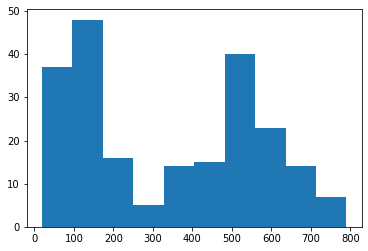

In [220]:
plt.hist(lgb_prediction)

In [219]:
lgb_prediction

array([458.15443924, 692.81376734, 211.28510421, 395.51809395,
       235.29035783, 100.79022383, 511.27280257, 344.87005045,
       579.20470516, 554.47848965, 548.23741004, 485.88405559,
       119.72444731, 504.78638489,  49.44707857,  68.83747638,
       645.52760471, 214.8537453 , 104.99738972, 234.19168601,
       603.69883024, 504.40516702,  87.19012168, 708.97140842,
        29.1145448 , 623.8525409 ,  95.60262325, 178.64079362,
       504.2875419 , 114.32802549, 593.96431668,  80.02994034,
       768.38832415, 569.00106016, 700.30894189, 134.52774837,
       504.03704247, 506.90061891, 613.93689826, 127.68372512,
       590.2893679 , 477.81798216, 495.19710176, 374.87654858,
       471.01517622, 681.82046147, 223.80934642,  99.39145314,
       506.30619785,  79.99468648, 734.38190796, 637.56837844,
       307.78778714, 704.31918389, 200.70691719, 127.40787012,
       102.98776423,  52.53082538, 769.44347883, 169.15029585,
       438.41643498, 642.40982251, 542.76295792, 102.42

(array([30., 55., 15., 11., 17., 20., 42., 21.,  5.,  3.]),
 array([ 15.69663393,  90.79451967, 165.89240541, 240.99029115,
        316.08817689, 391.18606263, 466.28394837, 541.38183411,
        616.47971985, 691.57760559, 766.67549133]),
 <a list of 10 Patch objects>)

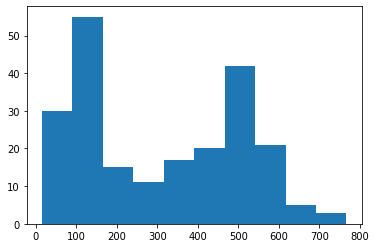

In [151]:
plt.hist(xgb_prediction)

In [ ]:
lgb_prediction = np.expm1(lgb_prediction)

In [ ]:
lgb_prediction1 = lgb_prediction

In [ ]:
lgb_prediction2 = lgb_prediction

In [ ]:
lgb_prediction3 = lgb_prediction

In [ ]:
lgb_prediction

In [ ]:
xgb_prediction

In [ ]:
mean_absolute_error(lgb_prediction,xgb_prediction)

In [152]:
res1 = 0.55*lgb_prediction+0.45*xgb_prediction

In [770]:
out2 = 0.55*lgb_prediction+0.45*xgb_prediction

In [850]:
out3 = 0.65*out1+ 0.35*out2

(array([29., 57., 11., 12., 16., 21., 39., 27.,  4.,  3.]),
 array([ 15.29830927,  87.64912267, 159.99993607, 232.35074946,
        304.70156286, 377.05237626, 449.40318965, 521.75400305,
        594.10481645, 666.45562984, 738.80644324]),
 <a list of 10 Patch objects>)

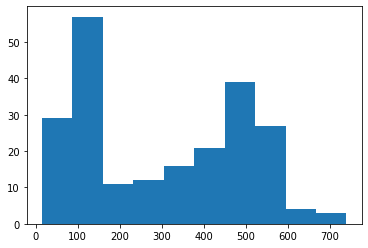

In [153]:
plt.hist(res1)

In [ ]:
l1 = lgb_prediction

In [ ]:
l1

In [ ]:
plt.hist(f_predictions)

In [ ]:
f_predictions

In [ ]:
xgb_prediction

In [ ]:
print("CV score: {:<8.5f}".format(((mean_squared_error(y, lgb_oof)))))

In [207]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RepeatedKFold 
train_stack = np.vstack([lgb_oof,xgb_oof]).transpose()
test_stack = np.vstack([lgb_prediction,xgb_prediction]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
f_predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], y.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    f_predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.5f}".format((mean_squared_error(oof_stack, y))))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 1111.92166


In [633]:
a1 = f_predictions

In [752]:
a2 = f_predictions

In [771]:
a_out = 0.2*a1 + 0.8*out2

In [ ]:
# f_out = out2*0.5 + a_out*0.5

In [ ]:
train_data.head()

In [221]:
print(pd.DataFrame({
        'column': feature_names,
        'importance': clf1.feature_importance(),
    }).sort_values(by='importance',ascending=False)[:200])

                                          column  importance
61                                 Haversine_min         583
404                                          a_v         560
60                                 Haversine_max         538
285                       hour_Haversine_min_min         516
46                                direction_mode         396
67                                Haversine_0.75         374
269                      hour_Haversine_mean_min         373
204                       hour_direction_min_max         371
98                                    speed_mean         364
284                       hour_Haversine_min_max         363
65                                Haversine_0.25         363
214                   hour_direction_medain_mean         360
51                                 work_time_ptp         357
42                                direction_0.75         356
39                            direction_kurtosis         342
256          hour_work_t

In [ ]:
data_test

In [184]:
res = pd.DataFrame()
res['loadingOrder'] = test_data['loadingOrder']

In [63]:
res.loc[res['loadingOrder']=='FA712454830300']

,loadingOrder,label
39,FA712454830300,418134.119349


In [222]:
res['label'] =lgb_prediction*3600

In [223]:
res['label'].apply(lambda x:pd.Timedelta(seconds=x))

0     19 days 02:09:15.981282
1     28 days 20:48:49.562417
2      8 days 19:17:06.375142
3     16 days 11:31:05.138207
4      9 days 19:17:25.288170
5      4 days 04:47:24.805802
6     21 days 07:16:22.089262
7     14 days 08:52:12.181603
8     24 days 03:12:16.938587
9     23 days 02:28:42.562735
10    22 days 20:14:14.676130
11    20 days 05:53:02.600142
12     4 days 23:43:28.010301
13    21 days 00:47:10.985594
14     2 days 01:26:49.482838
15     2 days 20:50:14.914972
16    26 days 21:31:39.376945
17     8 days 22:51:13.483095
18     4 days 08:59:50.602999
19     9 days 18:11:30.069636
20    25 days 03:41:55.788851
21    21 days 00:24:18.601255
22     3 days 15:11:24.438066
23    29 days 12:58:17.070303
24     1 days 05:06:52.361269
25    25 days 23:51:09.147243
26     3 days 23:36:09.443701
27     7 days 10:38:26.857040
28    21 days 00:17:15.150822
29     4 days 18:19:40.891777
30    24 days 17:57:51.540053
31     3 days 08:01:47.785239
32    32 days 00:23:17.966934
33    23 d

In [224]:
out = data_test
#c = pd.read_csv('./R2 ATest 0711.csv')
#out['timestamp'] = c['timestamp']
out = out.merge(res, on='loadingOrder', how='left')
#out['onboardDate'] = pd.to_datetime(out['onboardDate'], infer_datetime_format=True)
out['last_time'] = out.groupby(['loadingOrder'])['timestamp'].transform('max')
out['last_time'] = pd.to_datetime(out['last_time'], infer_datetime_format=True)
out['ETA'] = (out['last_time'] + out['label'].apply(lambda x:pd.Timedelta(seconds=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))

In [225]:
c = out[['loadingOrder','ETA']].drop_duplicates()

In [226]:
r = pd.read_csv('./R2 ATest 0711.csv')
r = r.merge(c, on='loadingOrder', how='left')
r['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')

In [227]:
result = r[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

In [172]:
#out = pd.read_csv('./R2 ATest 0711.csv')
out = data_test
c = pd.read_csv('./R2 ATest 0711.csv')
#out['timestamp'] = c['timestamp']
out = out.merge(res, on='loadingOrder', how='left')
#out['onboardDate'] = pd.to_datetime(out['onboardDate'], infer_datetime_format=True)
out['last_time'] = out.groupby(['loadingOrder'])['timestamp'].transform('max')
out['last_time'] = pd.to_datetime(out['last_time'], infer_datetime_format=True)
out['ETA'] = (out['last_time'] + out['label'].apply(lambda x:pd.Timedelta(seconds=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
c = c.merge(out[['loadingOrder','ETA']],on = 'loadingOrder',how = 'left')
#out.drop(['direction','TRANSPORT_TRACE','label','speed'],axis=1,inplace=True)
#out['onboardDate'] = out['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
c['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
#test_data['timestamp'] = test_data['temp_timestamp']
# 整理columns顺序
result = c[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

In [177]:
data_test.shape

(58682, 36)

In [167]:
data_test

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,lat_diff,lon_diff,speed_diff,diff_minutes,anchor,destins,start,q_lat,q_lon,lat_dis_diff,lon_dis_diff,base_dis_diff,d_lat,d_lon,Haversine,manhattan,mmin,work_time,average_speed,max_dis,len,work_time_diff,jiange,jiange_sum,period,periods
0,AC437723355280,2019-01-11T04:18:28.000Z,113.8750,22.390625,26.0,16064.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,0.0000,0.0000,NaN,NaN,0,CLVAP,CNSHK,22.562500,113.875,0.176025,0.032776,0.179077,-33.03125,-71.6250,18733206.0,18829364.0,2019-06-23 02:53:18+00:00,0.000000,0.000000,18733206.0,334,NaN,0,0,0,0
1,AC437723355280,2019-01-11T04:39:08.000Z,113.9375,22.359375,27.0,11912.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,-0.0233,-0.0233,1.0,8.0,0,CLVAP,CNSHK,22.562500,113.875,0.199341,0.054810,0.206787,-33.03125,-71.6250,18729918.0,18826584.0,2019-06-23 02:53:18+00:00,0.136108,24153.230469,18733206.0,334,0.136108,0,0,0,0
2,AC437723355280,2019-01-11T06:05:48.000Z,114.0000,22.343750,23.0,8624.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,-0.0149,-0.0149,-4.0,15.0,0,CLVAP,CNSHK,22.562500,113.875,0.214233,0.114624,0.242920,-33.03125,-71.6250,18725932.0,18824430.0,2019-06-23 02:53:18+00:00,0.388916,15764.879883,18733206.0,334,0.252930,0,0,0,0
3,AC437723355280,2019-01-11T08:48:28.000Z,114.0000,22.343750,23.0,9112.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,0.0001,0.0001,0.0,0.0,0,CLVAP,CNSHK,22.562500,113.875,0.214111,0.117188,0.244141,-33.03125,-71.6250,18725832.0,18824416.0,2019-06-23 02:53:18+00:00,0.397217,12029.700195,18733206.0,334,0.008301,0,0,0,0
4,AC437723355280,2019-01-11T09:50:58.000Z,114.0000,22.343750,23.0,9008.0,JCMFTA,G9916514058,2019/06/23 02:53:18,CNSHK-CLVAP,0.0000,0.0000,0.0,1.0,0,CLVAP,CNSHK,22.562500,113.875,0.214111,0.121033,0.245972,-33.03125,-71.6250,18725678.0,18824386.0,2019-06-23 02:53:18+00:00,0.413818,9300.280273,18733206.0,334,0.016602,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59381,ZZ318732594946,2020-04-29T13:12:59.000Z,120.9375,25.187500,33.0,3830.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.0000,0.0000,0.0,0.0,0,MXZLO,CNYTN,22.578125,114.250,2.611328,6.640625,7.132812,19.09375,-104.3125,13090549.0,14202028.0,2020-03-17 16:51:38+00:00,46.062500,0.000000,13781497.0,390,0.031250,1,0,1,0
59382,ZZ318732594946,2020-04-29T13:13:28.000Z,120.9375,25.234375,33.0,3770.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.0000,0.0000,0.0,0.0,0,MXZLO,CNYTN,22.578125,114.250,2.662109,6.683594,7.195312,19.09375,-104.3125,13083315.0,14204122.0,2020-03-17 16:51:38+00:00,46.281250,0.000000,13781497.0,390,0.218750,1,0,1,0
59383,ZZ318732594946,2020-04-29T13:13:52.000Z,121.0000,25.250000,33.0,3790.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.0000,0.0000,0.0,0.0,0,MXZLO,CNYTN,22.578125,114.250,2.675781,6.695312,7.210938,19.09375,-104.3125,13081487.0,14204650.0,2020-03-17 16:51:38+00:00,46.312500,0.000000,13781497.0,390,0.031250,1,0,1,0
59384,ZZ318732594946,2020-04-29T13:14:16.000Z,121.0000,25.250000,33.0,3790.0,OIEQNT,C7827726749,2020/03/17 16:51:38,CNYTN-MXZLO,0.0000,0.0000,0.0,0.0,0,MXZLO,CNYTN,22.578125,114.250,2.679688,6.699219,7.214844,19.09375,-104.3125,13081029.0,14204785.0,2020-03-17 16:51:38+00:00,46.343750,0.000000,13781497.0,390,0.031250,1,0,1,0


In [159]:
result

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,AC437723355280,2019-01-11T04:18:28.000Z,113.8750,22.390625,JCMFTA,G9916514058,2019/06/23 02:53:18,2019/02/16 05:29:51,2020/07/19 22:35:00
1,AC437723355280,2019-01-11T04:39:08.000Z,113.9375,22.359375,JCMFTA,G9916514058,2019/06/23 02:53:18,2019/02/16 05:29:51,2020/07/19 22:35:00
2,AC437723355280,2019-01-11T06:05:48.000Z,114.0000,22.343750,JCMFTA,G9916514058,2019/06/23 02:53:18,2019/02/16 05:29:51,2020/07/19 22:35:00
3,AC437723355280,2019-01-11T08:48:28.000Z,114.0000,22.343750,JCMFTA,G9916514058,2019/06/23 02:53:18,2019/02/16 05:29:51,2020/07/19 22:35:00
4,AC437723355280,2019-01-11T09:50:58.000Z,114.0000,22.343750,JCMFTA,G9916514058,2019/06/23 02:53:18,2019/02/16 05:29:51,2020/07/19 22:35:00
...,...,...,...,...,...,...,...,...,...
58677,ZZ318732594946,2020-04-29T13:12:59.000Z,120.9375,25.187500,OIEQNT,C7827726749,2020/03/17 16:51:38,2020/05/19 05:30:43,2020/07/19 22:35:00
58678,ZZ318732594946,2020-04-29T13:13:28.000Z,120.9375,25.234375,OIEQNT,C7827726749,2020/03/17 16:51:38,2020/05/19 05:30:43,2020/07/19 22:35:00
58679,ZZ318732594946,2020-04-29T13:13:52.000Z,121.0000,25.250000,OIEQNT,C7827726749,2020/03/17 16:51:38,2020/05/19 05:30:43,2020/07/19 22:35:00
58680,ZZ318732594946,2020-04-29T13:14:16.000Z,121.0000,25.250000,OIEQNT,C7827726749,2020/03/17 16:51:38,2020/05/19 05:30:43,2020/07/19 22:35:00


In [228]:
result.to_csv('fusai_result7.csv', index=False)

In [95]:
result

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,QM149151037282,2019-01-11T04:18:28.000Z,114.337167,22.556333,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/28 10:44:10,2020/07/20 20:57:04
1,QM149151037282,2019-01-11T04:39:08.000Z,114.426632,22.508475,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/28 10:44:10,2020/07/20 20:57:04
2,QM149151037282,2019-01-11T06:05:48.000Z,114.418000,22.182000,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/28 10:44:10,2020/07/20 20:57:04
3,QM149151037282,2019-01-11T08:48:28.000Z,114.101650,22.314968,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/28 10:44:10,2020/07/20 20:57:04
4,QM149151037282,2019-01-11T09:50:58.000Z,114.123500,22.324167,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/28 10:44:10,2020/07/20 20:57:04
...,...,...,...,...,...,...,...,...,...
77649,RA164708092311,2020-06-22T23:21:24.000Z,113.607726,18.704520,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:13:53,2020/07/20 20:57:04
77650,RA164708092311,2020-06-22T23:40:51.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:13:53,2020/07/20 20:57:04
77651,RA164708092311,2020-06-22T23:42:43.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:13:53,2020/07/20 20:57:04
77652,RA164708092311,2020-06-22T23:51:23.000Z,113.562748,18.547645,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:13:53,2020/07/20 20:57:04


In [203]:
b

,ETA
0,2019-02-02 07:07:28
43,2019-02-10 21:23:36
143,2019-02-19 12:51:57
183,2019-02-28 07:11:12
495,2019-02-26 15:02:36
533,2019-02-27 10:02:23
589,2019-03-02 18:34:57
1328,2019-03-05 08:26:57
1566,2019-03-12 20:29:21
4934,2019-04-01 22:25:11


In [238]:
a = pd.read_csv('./fusai_result7.csv')
b = pd.read_csv('./fusai_result6.csv')
c = pd.read_csv('./fusai_result1.csv')

In [256]:
c.loc[c['loadingOrder']=='FA712454830300']

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
29536,FA712454830300,2020-01-28T05:19:28.000Z,114.061383,22.359500,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
29537,FA712454830300,2020-01-28T05:24:28.000Z,114.074933,22.350750,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
29538,FA712454830300,2020-01-28T05:29:58.000Z,114.081983,22.329350,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
29541,FA712454830300,2020-01-28T05:30:28.000Z,114.082833,22.327083,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
29544,FA712454830300,2020-01-28T05:31:28.000Z,114.084383,22.323150,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
...,...,...,...,...,...,...,...,...,...
32945,FA712454830300,2020-02-23T07:41:08.000Z,31.126853,-29.817860,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
32946,FA712454830300,2020-02-23T07:43:08.000Z,31.125547,-29.818770,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
32947,FA712454830300,2020-02-23T07:46:08.000Z,31.119920,-29.818930,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34
32948,FA712454830300,2020-02-23T07:47:08.000Z,31.118000,-29.818530,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/28 20:13:57,2020/07/19 20:35:34


In [239]:
a['ETA'] =  pd.to_datetime(a['ETA'], infer_datetime_format=True)
a = a[['ETA']].drop_duplicates()
b['ETA'] =  pd.to_datetime(b['ETA'], infer_datetime_format=True)
b = b[['ETA']].drop_duplicates()

In [240]:
abs((a['ETA'] -b['ETA'] )).mean()

Timedelta('0 days 10:29:05.986175')

In [ ]:
plt.plot((a['ETA']-b['ETA'])/3600)

In [ ]:
plt.plot(b['ETA'])

In [ ]:
a_ETA

In [ ]:
b_ETA